# I] Import

In [1]:
import pandas, numpy, math, seaborn
import scipy, scipy.stats
import matplotlib, matplotlib.pyplot as plt
# this is a trick to make figures look nicer
matplotlib.rcParams.update({'font.size':20, 'font.family':'FreeSans', 'xtick.labelsize':20, 'ytick.labelsize':10, 'figure.figsize':(12, 8)})

In [2]:
# pip install matplotlib-venn

In [3]:
from matplotlib_venn import venn2

In [4]:
input_file_directory_atg7_expr = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7/0 Python Analysis/ATG7 analysis/'

## functions & options


In [5]:
#define a function to split after the ".". The 1 is for how many word to have. if we have several dot. The [1] is what is after the dot, and [0] what is before
def split(L):
  return L.split(".",1)[0]

# II] Dataframe download

## A) Isoform data

In [9]:
input_file_directory_subset = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7/0 Python Analysis/gene_expr_preparation/Organ_specific_samples/'
directory = input_file_directory_subset + 'samples_liver.tsv'
liver_samples = pandas.read_csv(directory, sep = "\t")

print(liver_samples.iloc[:,0:3].head())
print()
print(liver_samples['_sample_type'].value_counts())

                     sample                   samples   _sample_type
0  GTEX-1192X-1026-SM-5H12P  GTEX-1192X-1026-SM-5H12P  Normal Tissue
1  GTEX-11DXY-0526-SM-5EGGQ  GTEX-11DXY-0526-SM-5EGGQ  Normal Tissue
2  GTEX-11DXZ-0126-SM-5EGGY  GTEX-11DXZ-0126-SM-5EGGY  Normal Tissue
3  GTEX-11EQ9-0526-SM-5A5JZ  GTEX-11EQ9-0526-SM-5A5JZ  Normal Tissue
4  GTEX-11NUK-1226-SM-5P9GM  GTEX-11NUK-1226-SM-5P9GM  Normal Tissue

Primary Tumor    369
Normal Tissue    110
Name: _sample_type, dtype: int64


In [ ]:
#find number of normal tissue
nb_normal = len(liver_samples[liver_samples['_sample_type'] == 'Normal Tissue'])
print('nomber of normal tissue:', nb_normal)

#select normal and primary separatlydd
normal_liver_labels = liver_samples.iloc[:nb_normal ,0:1]
primary_liver_labels = liver_samples.iloc[nb_normal: ,0:1]
print(normal_liver_labels)

In [12]:
#subset
df_ATG7_Normal_liver = normal_liver_labels.merge(df_ATG7)
df_ATG7_Primary_liver = primary_liver_labels.merge(df_ATG7)

print(df_ATG7_Normal_liver.shape)
print(df_ATG7_Primary_liver.shape)
print(df_ATG7_Primary_liver.iloc[:,0:5].head())

(110, 20)
(369, 20)
            sample    Sample_Type Primary_Site   ATG7  ATG7_1
0  TCGA-2V-A95S-01  Primary Tumor        Liver  2.778   2.526
1  TCGA-2Y-A9GS-01  Primary Tumor        Liver  4.198   2.919
2  TCGA-2Y-A9GT-01  Primary Tumor        Liver  2.539   1.541
3  TCGA-2Y-A9GU-01  Primary Tumor        Liver  2.712   1.556
4  TCGA-2Y-A9GV-01  Primary Tumor        Liver  3.048   1.637


In [13]:
# create df with only Normal and Primary 
df_Norm_Prim = pandas.concat([df_ATG7_Normal_liver, df_ATG7_Primary_liver], axis=0)
df_Norm_Prim.reset_index(drop=True, inplace=True)

In [14]:
# What is the median for iso 1 and iso 2? If I want to create two groups
#High >50% and low <50%

Data = [[df_ATG7_Normal_liver, 'Normal_liver'], [df_ATG7_Primary_liver, 'Primary_liver']]
isoforms = [["ATG7_1", "iso1"], ["ATG7_2", "iso2"]]

df_LoHi = [] 

for df in Data:
  for isoform in isoforms:
    xMed = df[0][isoform[0]].median()

    low = df[0].loc[df[0][isoform[0]] < xMed]
    low['L/H'] = "Low_"+isoform[1]

    high = df[0].loc[df[0][isoform[0]] > xMed]
    high['L/H'] = "High_"+isoform[1]

  #merge low and high
  concat = pandas.concat([low, high], axis=0)
  col = concat.pop('L/H')
  concat.insert(3, 'L/H', col)
  df_LoHi.append(concat)

normal_LoHi = df_LoHi[0]
primary_LoHi = df_LoHi[1]

<ipython-input-14-8e1d3edae8bb>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low['L/H'] = "Low_"+isoform[1]
<ipython-input-14-8e1d3edae8bb>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high['L/H'] = "High_"+isoform[1]
<ipython-input-14-8e1d3edae8bb>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

## B) Whole gene expression

In [15]:
#download the protein coding list to do subset.
input_file_directory_gene_expr = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7/0 Python Analysis/gene_expr_preparation/'

directory = input_file_directory_gene_expr + "protein_coding_list.txt"
protein_coding_list= pandas.read_csv(directory, sep = "\t")
print(protein_coding_list.shape)
protein_coding_list.head()

(22796, 4)


,ensembl_gene_id,hgnc_symbol,entrezgene_id,transcript_biotype
1,ENSG00000198888,MT-ND1,4535.0,protein_coding
2,ENSG00000198763,MT-ND2,4536.0,protein_coding
3,ENSG00000198804,MT-CO1,4512.0,protein_coding
4,ENSG00000198712,MT-CO2,4513.0,protein_coding
5,ENSG00000228253,MT-ATP8,4509.0,protein_coding


In [16]:
%%time
# DL data gene expression for Normal Tissue and Primary Tumors
input_file_directory_gene_expr = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7/0 Python Analysis/gene_expr_preparation/'

directory = input_file_directory_gene_expr + "final_normal_protcoding_expr.tsv"
normal_protcoding= pandas.read_csv(directory, sep = "\t")
print(normal_protcoding.shape)

directory = input_file_directory_gene_expr + "final_primary_protcoding_expr.tsv"
primary_protcoding= pandas.read_csv(directory, sep = "\t")
print(primary_protcoding.shape)
primary_protcoding.head(2)

(7429, 19383)
(9185, 19383)
Wall time: 3min 29s


,sample,ENSG00000198888,ENSG00000198763,ENSG00000198804,ENSG00000198712,ENSG00000228253,ENSG00000198899,ENSG00000198938,ENSG00000198840,ENSG00000212907,...,ENSG00000160678,ENSG00000160679,ENSG00000143553,ENSG00000214193,ENSG00000196182,ENSG00000181817,ENSG00000116885,ENSG00000116898,ENSG00000119535,ENSG00000142694
0,TCGA-02-0047-01,12.9202,13.1220,14.0136,13.5251,13.8439,13.7777,13.4037,12.8123,13.4187,...,6.4741,5.8017,6.4975,2.1509,5.2445,6.0507,3.8915,5.5389,4.2936,4.6685
1,TCGA-02-0055-01,10.3972,10.7774,12.3945,12.3893,11.7280,11.9408,12.2022,11.0142,11.0221,...,5.9969,5.6888,6.0633,1.9822,4.3299,6.4992,3.7582,6.7092,4.5964,5.5145


In [17]:
#see how many duplicates in genes
print('normal shape:', normal_protcoding.shape)
print('number of duplicated genes:', normal_protcoding.columns.duplicated().sum())
print()
print('primary shape is:', primary_protcoding.shape)
print('number of duplicated genes:', primary_protcoding.columns.duplicated().sum())

normal shape: (7429, 19383)
number of duplicated genes: 0

primary shape is: (9185, 19383)
number of duplicated genes: 0


In [18]:
#Preparation of the global dataframe with ATG7
data = [[normal_protcoding, df_ATG7_Normal_liver], [primary_protcoding, df_ATG7_Primary_liver]]

df_final = []

for df in data:
    #Merge the two df to have ATG7 isoform expression + whole gene expression 
  df_merged = pandas.merge(df[1], df[0], on= 'sample')

  #delete the sample column and select column
  df_merged = df_merged.drop("sample", 1)
  df_merged = df_merged.drop(df_merged.columns[5:19], axis=1)
  
  #save in list
  df_final.append(df_merged)

normal_liver_protcoding_atg7_expr = df_final[0]
primary_liver_protcoding_atg7_expr = df_final[1]

print(normal_liver_protcoding_atg7_expr.shape)
print(primary_liver_protcoding_atg7_expr.shape)
normal_liver_protcoding_atg7_expr.head()

(110, 19387)
(369, 19387)


,Sample_Type,Primary_Site,ATG7,ATG7_1,ATG7_2,ENSG00000198888,ENSG00000198763,ENSG00000198804,ENSG00000198712,ENSG00000228253,...,ENSG00000160678,ENSG00000160679,ENSG00000143553,ENSG00000214193,ENSG00000196182,ENSG00000181817,ENSG00000116885,ENSG00000116898,ENSG00000119535,ENSG00000142694
0,Normal Tissue,Liver,3.2590,2.7010,-1.4310,8.9743,11.2312,10.6905,12.2497,12.0025,...,1.7229,5.9892,5.4738,3.0550,4.8929,4.9031,3.2766,6.3815,3.3278,6.2589
1,Normal Tissue,Liver,1.1510,0.4233,-9.9660,14.0574,14.9857,15.4510,15.6933,15.7066,...,1.6740,4.2033,3.7302,-1.6850,3.6939,3.9892,-0.5332,5.4047,1.1117,1.2934
2,Normal Tissue,Liver,2.0180,0.7579,-1.0260,13.7023,14.2477,15.0063,15.3722,15.7625,...,0.8488,4.2358,4.0144,-0.1828,3.8421,3.7794,0.5568,5.3636,2.4883,2.9674
3,Normal Tissue,Liver,2.1480,0.4967,0.7407,13.4143,13.4795,14.9369,14.8399,15.1462,...,0.9115,4.3674,4.0918,0.1648,3.6725,4.1923,-0.1665,5.4970,2.6602,2.4090
4,Normal Tissue,Liver,0.9862,0.8082,-9.9660,14.3363,14.7825,15.5120,15.7519,16.3256,...,0.9935,4.2518,3.8511,-1.7322,2.9581,3.1765,-0.3383,5.3611,2.7847,1.7316


# III] ATG7 expression

## A) Distribution


findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans.


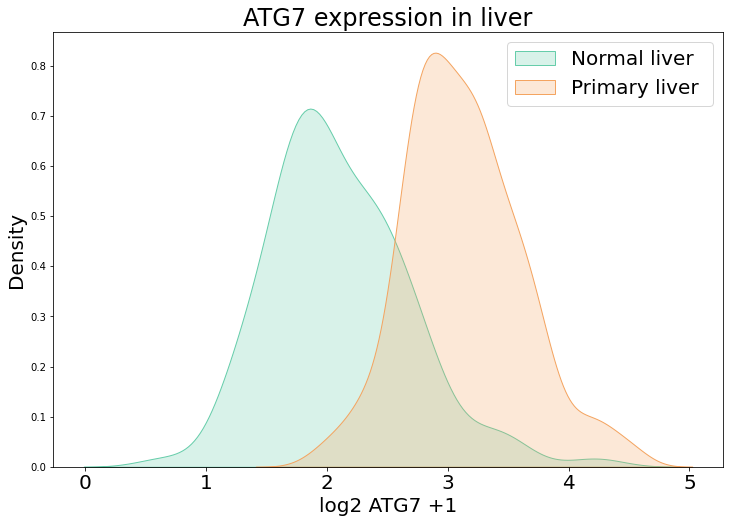

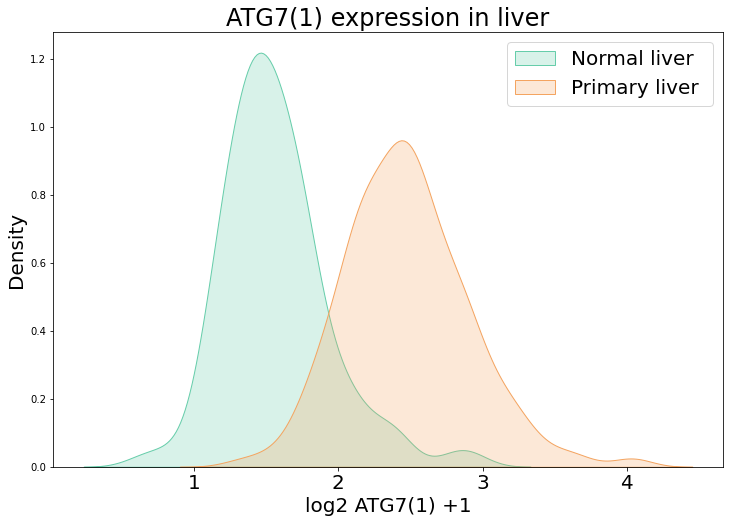

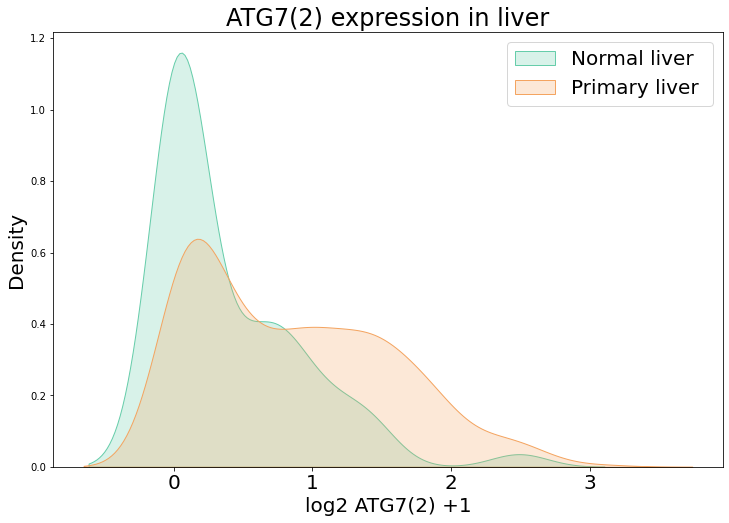

<Figure size 864x576 with 0 Axes>

In [19]:
# Distribution graph, for ATG7, iso1 & iso2
all_dfs = [[df_ATG7_Normal_liver, 'in liver', df_ATG7_Primary_liver, 'in primary liver']]

isoforms = [['log2_+1_ATG7(total)', 'ATG7'], ['log2_+1_ATG7(1)', 'ATG7(1)'], ['log2_+1_ATG7(2)', 'ATG7(2)']]


for df in all_dfs:
  for isoform in isoforms:
    xData = df[0][isoform[0]]
    x2Data = df[2][isoform[0]]

    seaborn.kdeplot(xData, color = 'mediumaquamarine', fill = True)
    seaborn.kdeplot(x2Data, color = 'sandybrown', fill = True)

    plt.xlabel('log2 '+ isoform[1]+ ' +1')
    plt.title(isoform[1]+ ' expression ' + df[1] )
    plt.legend(labels=["Normal liver","Primary liver "])
    plt.show()
    plt.clf()

## B) Percentage do not express ATG7 isoforms

In [20]:
#Percentage of patients: 
all_dfs = [[df_ATG7_Normal_liver, 'normal liver'], [df_ATG7_Primary_liver, 'primary liver']]

isoforms = [['ATG7(total)', 'ATG7'], ['ATG7(1)', 'ATG7(1)'], ['ATG7(2)', 'ATG7(2)'], ['ATG7(3)', 'ATG7(3)']]

for df in all_dfs:
  print(df[1])
  for isoform in isoforms:
        
    QUOI = isoform[1]
    OU = df[1]
    all = (df[0][isoform[0]]).shape
    no_exp = (df[0][isoform[0]]<0.1).sum()
    perc_no_exp = (no_exp*100)/all
    perc_no_exp = float(perc_no_exp)

    # print("The percentage of patient who do not express", QUOI, OU, "is:", round(perc_no_exp,1),'%')
    print(round(perc_no_exp,1),'% of tumor do not express', QUOI)
  print()


normal liver
0.0 % of tumor do not express ATG7
0.0 % of tumor do not express ATG7(1)
56.4 % of tumor do not express ATG7(2)
79.1 % of tumor do not express ATG7(3)

primary liver
0.0 % of tumor do not express ATG7
0.0 % of tumor do not express ATG7(1)
20.3 % of tumor do not express ATG7(2)
48.8 % of tumor do not express ATG7(3)



## C) Expression figures

### 1) Value TPM

479


<ipython-input-21-408604e1a98a>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_distrib['x'][: shape] = 'ATG7'
C:\Users\kja11\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-21-408604e1a98a>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_distrib['x'][shape: shape*2] = 'ATG7(1)'
<ipython-input-21-408604e1a98a>:

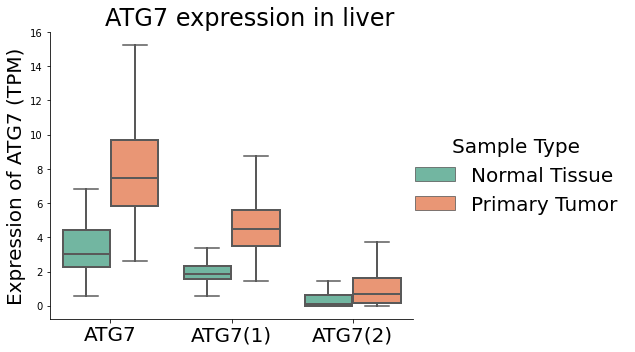

In [21]:
# Distribution: Data preparation + graph
data = [[df_Norm_Prim, 'liver']]

for df in data:
   
  shape = df[0].shape
  shape = shape[0]
  print(shape)

  #select the sample type column
  sample_type = {'sample_type':[df[0].iloc[:,1][i]
      for i in range(0, shape)]}

  #convert to df, and copy it 3 times
  sample_typedf = pandas.DataFrame(sample_type)
  sample_typedf = pandas.concat([sample_typedf,sample_typedf,sample_typedf])
  sample_typedf.reset_index(drop=True, inplace=True)

  # Y for expression value 
  y = {'y':[df[0].iloc[:,j][i]
      for j in range(7,10)
        for i in range(0, shape)]}

  #create df with Y 
  data_distrib = pandas.DataFrame(y)

  # X for ATG7/iso1/iso2
  data_distrib['x'] = ''
  data_distrib['x'][: shape] = 'ATG7'
  data_distrib['x'][shape: shape*2] = 'ATG7(1)'
  data_distrib['x'][shape*2:] = 'ATG7(2)'

  # Will be used for Hue
  data_distrib['Sample Type'] = sample_typedf['sample_type']

  #graph
  seaborn.catplot(x="x", y="y", hue="Sample Type", aspect= 1.2, kind="box", palette = 'Set2', data = data_distrib, 
                  boxprops={'lw':2}, medianprops={'lw':2}, whiskerprops={'lw':2}, showcaps=True, showfliers=False)
  
  plt.ylabel('Expression of ATG7 (TPM)')
  plt.xlabel('')
  plt.title('ATG7 expression in '+ df[1], x=.55)

479


<ipython-input-22-7295dd2bb464>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_distrib['x'][: shape] = 'ATG7(1)'
C:\Users\kja11\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-22-7295dd2bb464>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_distrib['x'][shape: shape*2] = 'ATG7(2)'


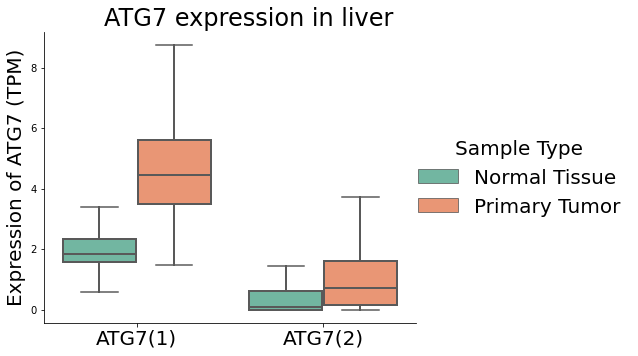

In [22]:
# Distribution: Data preparation + graph
data = [[df_Norm_Prim, 'liver']]

for df in data:
   
  shape = df[0].shape
  shape = shape[0]
  print(shape)

  #select the sample type column
  sample_type = {'sample_type':[df[0].iloc[:,1][i]
      for i in range(0, shape)]}

  #convert to df, and copy it 3 times
  sample_typedf = pandas.DataFrame(sample_type)
  sample_typedf = pandas.concat([sample_typedf,sample_typedf,sample_typedf])
  sample_typedf.reset_index(drop=True, inplace=True)

  # Y for expression value 
  y = {'y':[df[0].iloc[:,j][i]
      for j in range(8,10)
        for i in range(0, shape)]}

  #create df with Y 
  data_distrib = pandas.DataFrame(y)

  # X for ATG7/iso1/iso2
  data_distrib['x'] = ''
  data_distrib['x'][: shape] = 'ATG7(1)'
  data_distrib['x'][shape: shape*2] = 'ATG7(2)'

  # Will be used for Hue
  data_distrib['Sample Type'] = sample_typedf['sample_type']

  #graph
  seaborn.catplot(x="x", y="y", hue="Sample Type", aspect= 1.2, kind="box", palette = 'Set2', data = data_distrib, 
                  boxprops={'lw':2}, medianprops={'lw':2}, whiskerprops={'lw':2}, showcaps=True, showfliers=False)
  
  plt.ylabel('Expression of ATG7 (TPM)')
  plt.xlabel('')
  plt.title('ATG7 expression in '+ df[1], x=.55)

In [23]:
#Distribution: Stats for all 

all_dfs = [[df_ATG7_Normal_liver, 'all Normal liver', df_ATG7_Primary_liver, 'in primary liver']]

isoforms = ['ATG7', 'ATG7(1)', 'ATG7(2)']

for df in all_dfs:
  for isoform in isoforms:

    n1 = "{:.3f}".format(numpy.median(df[0][isoform]))
    n2 = "{:.3f}".format(numpy.median(df[2][isoform]))

    # Mann-Whitney analysis 
    statistic, pvalue = scipy.stats.mannwhitneyu(df[0][isoform], df[2][isoform])
    Pvalue = "{:.3E}".format(pvalue)
    print("the pvalue between", df[1]+'('+n1+')', "and", df[3]+'('+n2+')', "for", isoform, 'is', Pvalue)
  print()


the pvalue between all Normal liver(1.590) and in primary liver(2.905) for ATG7 is 1.132E-40
the pvalue between all Normal liver(1.850) and in primary liver(4.459) for ATG7(1) is 1.889E-46
the pvalue between all Normal liver(0.080) and in primary liver(0.710) for ATG7(2) is 6.641E-13



In [24]:
#median brut file to compare 
print(df_Norm_Prim['ATG7(total)'].mean())
print(df_Norm_Prim['ATG7(1)'].mean())
print(df_Norm_Prim['ATG7(2)'].mean())

7.213377112049965
4.186425883335846
0.9104266528900931


In [25]:
#median after modification to be sure I selected the good ones
data_distribtest = data_distrib[data_distrib['x'] == 'ATG7']
data_distribtest1 = data_distrib[data_distrib['x'] == 'ATG7(1)']
data_distribtest2 = data_distrib[data_distrib['x'] == 'ATG7(2)']
print('tot →', data_distribtest.mean())
print('(1) →',data_distribtest1.mean())
print('(2) →',data_distribtest2.mean())

tot → y             NaN
x             NaN
Sample Type   NaN
dtype: float64
(1) → y    4.186426
dtype: float64
(2) → y    0.910427
dtype: float64


### 2) Normalized

479


<ipython-input-26-a237ff7ea727>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_distrib['x'][: shape] = 'ATG7(1)/ATG7'
C:\Users\kja11\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-26-a237ff7ea727>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_distrib['x'][shape:] = 'ATG7(2)/ATG7'


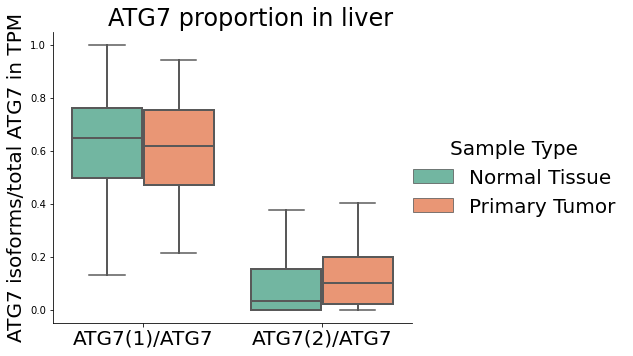

In [26]:
# NORMALiZED Distribution: Data preparation + graph

data = [[df_Norm_Prim, 'liver']]

for df in data:
   
  shape = df[0].shape
  shape = shape[0]
  print(shape)

  #select the sample type column
  sample_type = {'sample_type':[df[0].iloc[:,1][i]
      for i in range(0, shape)]}

  #convert to df, and copy it 3 times
  sample_typedf = pandas.DataFrame(sample_type)
  sample_typedf = pandas.concat([sample_typedf,sample_typedf,sample_typedf])
  sample_typedf.reset_index(drop=True, inplace=True)

  # Y for expression value 
  y = {'y':[df[0].iloc[:,j][i]
      for j in range(18,20)
        for i in range(0, shape)]}

  #create df with Y 
  data_distrib = pandas.DataFrame(y)

  # X for iso1/ATG7 and iso2/ATG7
  data_distrib['x'] = ''
  data_distrib['x'][: shape] = 'ATG7(1)/ATG7'
  data_distrib['x'][shape:] = 'ATG7(2)/ATG7'


  # Will be used for Hue
  data_distrib['Sample Type'] = sample_typedf['sample_type']

  #graph
  seaborn.catplot(x="x", y="y", hue="Sample Type", aspect= 1.2, kind="box", palette = 'Set2', data = data_distrib, 
                  boxprops={'lw':2}, medianprops={'lw':2}, whiskerprops={'lw':2}, showcaps=True, showfliers=False)
  
  plt.ylabel('ATG7 isoforms/total ATG7 in TPM')
  plt.xlabel('')
  plt.title('ATG7 proportion in '+ df[1], x=0.55)


In [27]:
#NORMALIZED Distribution: Stats for all 

all_dfs = [[df_ATG7_Normal_liver, 'in normal liver', df_ATG7_Primary_liver, 'in primary liver']]

isoforms = ['ATG7(1)norm', 'ATG7(2)norm']
print('NORMALIZED')

for df in all_dfs:
  for isoform in isoforms:

    n1 = "{:.3f}".format(numpy.median(df[0][isoform]))
    n2 = "{:.3f}".format(numpy.median(df[2][isoform]))

    # Mann-Whitney analysis 
    statistic, pvalue = scipy.stats.mannwhitneyu(df[0][isoform], df[2][isoform])
    Pvalue = "{:.3E}".format(pvalue)
    print("the pvalue between", df[1]+'('+n1+')', "and", df[3]+'('+n2+')', "for", isoform, 'is', Pvalue)
  print()


NORMALIZED
the pvalue between in normal liver(0.651) and in primary liver(0.617) for ATG7(1)norm is 1.432E-01
the pvalue between in normal liver(0.032) and in primary liver(0.099) for ATG7(2)norm is 1.118E-06



# IV] Expression correlation 

## 1) between the two isoforms

In [31]:
len(no_extrem_iso)

4

In [67]:
no_extrem_iso[2]

,sample,Sample_Type,Primary_Site,ATG7,ATG7_1,ATG7_2,ATG7_3,ATG7(total),ATG7(1),ATG7(2),ATG7(3),log2_+1_ATG7(total),log2_+1_ATG7(1),log2_+1_ATG7(2),ATG7_prot_tot,ATG7_1%,ATG7_2%,ATG7_3%,ATG7(1)norm,ATG7(2)norm
146,TCGA-DD-A73F-01,Primary Tumor,Liver,3.152,1.774,1.836,-1.2480,8.887870,3.419009,3.569188e+00,4.200315e-01,3.305660,2.143723,2.191938e+00,7.408228,46.151504,48.178699,5.669797,0.384683,4.015797e-01
262,TCGA-FV-A3R3-01,Primary Tumor,Liver,3.563,2.177,1.783,0.6699,11.817705,4.521122,3.440411e+00,1.589963e+00,3.680066,2.464962,2.150693e+00,9.551495,47.334182,36.019601,16.646217,0.382572,2.911234e-01
361,TCGA-ZP-A9D0-01,Primary Tumor,Liver,3.536,1.907,1.732,0.6790,11.598575,3.749284,3.320880e+00,1.600030e+00,3.655189,2.247710,2.111325e+00,8.670194,43.243373,38.302258,18.454369,0.323254,2.863179e-01
260,TCGA-FV-A3I1-01,Primary Tumor,Liver,3.597,2.170,1.628,0.4340,12.099544,4.499234,3.089842e+00,1.349974e+00,3.711445,2.459231,2.032045e+00,8.939050,50.332349,34.565666,15.101986,0.371852,2.553685e-01
97,TCGA-DD-A11D-01,Primary Tumor,Liver,3.184,1.892,1.609,-2.3150,9.087234,3.710494,3.049403e+00,1.999627e-01,3.334459,2.235878,2.017709e+00,6.959860,53.312767,43.814147,2.873086,0.408319,3.355700e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,TCGA-CC-A9FV-01,Primary Tumor,Liver,3.240,2.899,-9.966,-9.9660,9.446941,7.458092,-1.495113e-07,-1.495113e-07,3.385009,3.080332,-2.156992e-07,7.458092,100.000004,-0.000002,-0.000002,0.789472,-1.582642e-08
82,TCGA-CC-A8HU-01,Primary Tumor,Liver,2.872,2.406,-9.966,-9.9660,7.319793,5.299028,-1.495113e-07,-1.495113e-07,3.056548,2.655129,-2.156992e-07,5.299028,100.000006,-0.000003,-0.000003,0.723931,-2.042562e-08
76,TCGA-CC-A7II-01,Primary Tumor,Liver,2.573,2.189,-9.966,-9.9660,5.949455,4.558893,-1.495113e-07,-1.495113e-07,2.796900,2.474798,-2.156992e-07,4.558893,100.000007,-0.000003,-0.000003,0.766271,-2.513025e-08
231,TCGA-DD-AAW3-01,Primary Tumor,Liver,2.590,2.050,-9.966,-0.8339,6.019987,4.140060,-1.495113e-07,5.600106e-01,2.811468,2.361785,-2.156992e-07,4.700070,88.085061,-0.000003,11.914942,0.687719,-2.483582e-08


##2) between all protein coding

In [45]:
#to know the ensembl code for HK2
protein_coding_list.loc[protein_coding_list['hgnc_symbol'] == 'MFAP3']

,ensembl_gene_id,hgnc_symbol,entrezgene_id,transcript_biotype
19160,ENSG00000037749,MFAP3,4238.0,protein_coding


In [46]:
# Spearman Correlation, main genes 
all_tissue_used = [[normal_liver_protcoding_atg7_expr,'Normal liver'], [primary_liver_protcoding_atg7_expr,'Primary liver']]

HK2 = 'ENSG00000159399'
YAP1 = 'ENSG00000137693'
AJUBA = 'ENSG00000129474'
YBX1 = 'ENSG00000065978'
TGFB1 = 'ENSG00000105329'
ATG7_1 = 'ATG7_1'
ATG7_2 = 'ATG7_2'
MTDH = 'ENSG00000147649'
MAPK1 = 'ENSG00000100030'
KPNA1 = 'ENSG00000114030'
TNPO1 = 'ENSG00000083312'

for tissue in all_tissue_used:
  genes_x = [[KPNA1,'KPNA1'], [MAPK1, 'MAPK1'], [TNPO1,'TNPO1'], [MTDH,'MTDH'], 
             [HK2, "HK2"], [YAP1, 'YAP1'], [AJUBA,'AJUBA'], [YBX1,'YBX1'], 
             [TGFB1,'TGFB1'], [ATG7_1,'ATG7_1'], [ATG7_2,'ATG7_2']]

  print(tissue[1])

  for gene in genes_x:
    x = tissue[0][gene[0]].to_list()
    y = tissue[0]['ATG7'].to_list()
    y1 = tissue[0]['ATG7_1'].to_list()
    y2 = tissue[0]['ATG7_2'].to_list()  
  
    r_value, p_value = scipy.stats.spearmanr(x, y)
    print('  correlation between ATG7 and', gene[1],  'is:', 'r_value = {:.2f} for a p_value of {:.2e}'.format(r_value, p_value))
    r_value, p_value = scipy.stats.spearmanr(x, y1)
    print('  correlation between ATG7_1 and', gene[1],  'is:', 'r_value = {:.2f} for a p_value of {:.2e}'.format(r_value, p_value))
    r_value, p_value = scipy.stats.spearmanr(x, y2)
    print('  correlation between ATG7_2 and', gene[1],  'is:', 'r_value = {:.2f} for a p_value of {:.2e}'.format(r_value, p_value))
    print()

Normal liver
  correlation between ATG7 and KPNA1 is: r_value = 0.77 for a p_value of 7.47e-23
  correlation between ATG7_1 and KPNA1 is: r_value = 0.33 for a p_value of 3.57e-04
  correlation between ATG7_2 and KPNA1 is: r_value = 0.64 for a p_value of 3.06e-14

  correlation between ATG7 and MAPK1 is: r_value = 0.79 for a p_value of 2.41e-24
  correlation between ATG7_1 and MAPK1 is: r_value = 0.45 for a p_value of 9.12e-07
  correlation between ATG7_2 and MAPK1 is: r_value = 0.66 for a p_value of 5.00e-15

  correlation between ATG7 and TNPO1 is: r_value = 0.78 for a p_value of 3.75e-24
  correlation between ATG7_1 and TNPO1 is: r_value = 0.47 for a p_value of 2.00e-07
  correlation between ATG7_2 and TNPO1 is: r_value = 0.59 for a p_value of 7.47e-12

  correlation between ATG7 and MTDH is: r_value = 0.63 for a p_value of 2.80e-13
  correlation between ATG7_1 and MTDH is: r_value = 0.35 for a p_value of 2.02e-04
  correlation between ATG7_2 and MTDH is: r_value = 0.52 for a p_value

In [47]:
normal_liver_protcoding_atg7_expr.head()

,Sample_Type,Primary_Site,ATG7,ATG7_1,ATG7_2,ENSG00000198888,ENSG00000198763,ENSG00000198804,ENSG00000198712,ENSG00000228253,...,ENSG00000160678,ENSG00000160679,ENSG00000143553,ENSG00000214193,ENSG00000196182,ENSG00000181817,ENSG00000116885,ENSG00000116898,ENSG00000119535,ENSG00000142694
0,Normal Tissue,Liver,3.2590,2.7010,-1.4310,8.9743,11.2312,10.6905,12.2497,12.0025,...,1.7229,5.9892,5.4738,3.0550,4.8929,4.9031,3.2766,6.3815,3.3278,6.2589
1,Normal Tissue,Liver,1.1510,0.4233,-9.9660,14.0574,14.9857,15.4510,15.6933,15.7066,...,1.6740,4.2033,3.7302,-1.6850,3.6939,3.9892,-0.5332,5.4047,1.1117,1.2934
2,Normal Tissue,Liver,2.0180,0.7579,-1.0260,13.7023,14.2477,15.0063,15.3722,15.7625,...,0.8488,4.2358,4.0144,-0.1828,3.8421,3.7794,0.5568,5.3636,2.4883,2.9674
3,Normal Tissue,Liver,2.1480,0.4967,0.7407,13.4143,13.4795,14.9369,14.8399,15.1462,...,0.9115,4.3674,4.0918,0.1648,3.6725,4.1923,-0.1665,5.4970,2.6602,2.4090
4,Normal Tissue,Liver,0.9862,0.8082,-9.9660,14.3363,14.7825,15.5120,15.7519,16.3256,...,0.9935,4.2518,3.8511,-1.7322,2.9581,3.1765,-0.3383,5.3611,2.7847,1.7316


In [48]:
primary_liver_protcoding_atg7_expr.head()

,Sample_Type,Primary_Site,ATG7,ATG7_1,ATG7_2,ENSG00000198888,ENSG00000198763,ENSG00000198804,ENSG00000198712,ENSG00000228253,...,ENSG00000160678,ENSG00000160679,ENSG00000143553,ENSG00000214193,ENSG00000196182,ENSG00000181817,ENSG00000116885,ENSG00000116898,ENSG00000119535,ENSG00000142694
0,Primary Tumor,Liver,2.778,2.526,-2.1780,10.7384,11.9699,11.7672,13.1304,11.6930,...,2.4675,6.0665,5.4209,-0.2159,4.0091,5.3352,-0.3940,6.4346,3.2220,2.7847
1,Primary Tumor,Liver,4.198,2.919,2.0110,12.3783,12.1026,13.7137,13.2767,13.0898,...,2.1606,5.6996,5.1157,0.0014,4.2220,5.1962,-0.5125,6.6128,1.9931,3.8340
2,Primary Tumor,Liver,2.539,1.541,-0.3752,12.0660,12.0678,13.7570,13.5460,13.8357,...,1.5266,4.3702,4.1111,-0.8599,4.0375,4.5129,-0.5973,5.6542,1.3956,2.3366
3,Primary Tumor,Liver,2.712,1.556,1.0500,12.6688,12.9656,14.8855,14.5545,14.2781,...,0.9115,5.0674,4.8213,0.2029,3.1556,4.6668,0.3796,6.4754,-0.8084,1.7617
4,Primary Tumor,Liver,3.048,1.637,1.0430,13.1180,13.5375,14.1719,13.8771,13.9111,...,0.5370,4.4686,4.3140,-1.1172,3.9910,4.5280,0.4761,5.8810,1.1447,2.7183


In [49]:
%%time
#Have to exclude ATG7(2) of the tpm selection because max in lower than 5tpm
# Spearman Correlation, all genes WITHOUT cutoff

all_tissue_used = [[normal_liver_protcoding_atg7_expr,'Normal_liver'], [primary_liver_protcoding_atg7_expr,'Primary_liver']]

isoforms = ['ATG7_1', 'ATG7_2']

all_positiv_corr_spearman = []
all_negativ_corr_spearman = []

for tissue in all_tissue_used:
    the_tissue = tissue[0].copy()
    print(tissue[1], the_tissue.shape)

    #create a new row with max() for each gene and transpose
    the_tissue.loc['max()'] = the_tissue.max()

    #select iso 2 row (because ATG72 is lower than 5tpm) and transpose
    col_youwanttomove = the_tissue.loc[:,'ATG7_2']
    print(the_tissue.iloc[:,0:5].head())
    the_tissue.drop(labels=['ATG7_2'], axis=1, inplace = True)

    the_tissue = the_tissue.T

    #select all row where max() > 2.3 (= 5 tpm)
    nb_before = the_tissue['max()'].count()
    the_tissue = the_tissue.drop(the_tissue.index[0:2])
    the_tissue = the_tissue[the_tissue['max()'] > 2.3]

    #delete the column max() and tranpose back
    the_tissue =  the_tissue.drop('max()', axis = 1) 
    the_tissue = the_tissue.T
    print('nombre genes after removing < 4tpm', the_tissue.shape)

    #add back iso2 row
    the_tissue.insert(1, 'ATG7_2', col_youwanttomove)

    print(the_tissue.iloc[:,0:4].head())
    
    for isoform in isoforms:

        genepos = []
        geneneg = []
        rvaluepos = []
        rvalueneg = []
        pvaluepos = []
        pvalueneg = []

        print(isoform)
        x = the_tissue[isoform].to_list()
        genes = the_tissue.columns[3:]

        for gene in genes:
          y = the_tissue[gene].to_list()
          r_value, p_value = scipy.stats.spearmanr(x, y)

          if r_value > 0:
            genepos.append(gene)
            rvaluepos.append(r_value)
            pvaluepos.append(p_value)

          elif r_value < 0:
            geneneg.append(gene)
            rvalueneg.append(r_value)
            pvalueneg.append(p_value)

        #create a dictionnary
        d = dict(ensembl_gene_id= genepos, r_value=rvaluepos,  p_value=pvaluepos)
        d2 = dict(ensembl_gene_id= geneneg, r_value=rvalueneg,  p_value=pvalueneg)

        #Convert to dataframe
        df_positiv_corr = pandas.DataFrame.from_dict(d, orient='index')
        df_negativ_corr = pandas.DataFrame.from_dict(data=d2, orient='index')

        #Transpose to have a better table
        df_positiv_corr = df_positiv_corr.transpose()
        df_negativ_corr = df_negativ_corr.transpose()

        #name
        positiv_corr = 'pos_spearman_corr_'+tissue[1]+'_'+isoform
        negativ_corr = 'neg_spearman_corr_'+tissue[1]+'_'+isoform

        print(positiv_corr, df_positiv_corr.shape)
        print(negativ_corr, df_negativ_corr.shape)

        #scending orde, save to excel
        df_positiv_corr['info'] = tissue[1]+'_'+isoform
        df_positiv_corr = protein_coding_list.merge(df_positiv_corr)
        df_positiv_corr = df_positiv_corr.drop(['entrezgene_id', 'transcript_biotype'], axis = 1)
        df_positiv_corr = df_positiv_corr.sort_values(['r_value'], ascending = False)
        #     df_positiv_corr.to_excel(positiv_corr+'.xlsx', index=False)

        df_negativ_corr['info'] = tissue[1]+'_'+isoform
        df_negativ_corr = protein_coding_list.merge(df_negativ_corr)
        df_negativ_corr = df_negativ_corr.drop(['entrezgene_id', 'transcript_biotype'], axis = 1)
        df_negativ_corr = df_negativ_corr.sort_values(['r_value'], ascending = False)
        #     df_negativ_corr.to_excel(negativ_corr+'.xlsx', index=False)

        all_positiv_corr_spearman.append(df_positiv_corr)
        all_negativ_corr_spearman.append(df_negativ_corr)
        print('length of the list:', len(all_positiv_corr_spearman))
print()

Normal_liver (110, 19387)
     Sample_Type Primary_Site    ATG7  ATG7_1  ATG7_2
0  Normal Tissue        Liver  3.2590  2.7010 -1.4310
1  Normal Tissue        Liver  1.1510  0.4233 -9.9660
2  Normal Tissue        Liver  2.0180  0.7579 -1.0260
3  Normal Tissue        Liver  2.1480  0.4967  0.7407
4  Normal Tissue        Liver  0.9862  0.8082 -9.9660
nombre genes after removing < 4tpm (110, 12582)
     ATG7  ATG7_2  ATG7_1 ENSG00000198888
0   3.259 -1.4310   2.701          8.9743
1   1.151 -9.9660  0.4233         14.0574
2   2.018 -1.0260  0.7579         13.7023
3   2.148  0.7407  0.4967         13.4143
4  0.9862 -9.9660  0.8082         14.3363
ATG7_1
pos_spearman_corr_Normal_liver_ATG7_1 (11477, 3)
neg_spearman_corr_Normal_liver_ATG7_1 (1103, 3)
length of the list: 1
ATG7_2
pos_spearman_corr_Normal_liver_ATG7_2 (9448, 3)
neg_spearman_corr_Normal_liver_ATG7_2 (3132, 3)
length of the list: 2
Primary_liver (369, 19387)
     Sample_Type Primary_Site   ATG7  ATG7_1  ATG7_2
0  Primary Tumor   

In [50]:
primary_liver_protcoding_atg7_expr

,Sample_Type,Primary_Site,ATG7,ATG7_1,ATG7_2,ENSG00000198888,ENSG00000198763,ENSG00000198804,ENSG00000198712,ENSG00000228253,...,ENSG00000160678,ENSG00000160679,ENSG00000143553,ENSG00000214193,ENSG00000196182,ENSG00000181817,ENSG00000116885,ENSG00000116898,ENSG00000119535,ENSG00000142694
0,Primary Tumor,Liver,2.778,2.526,-2.1780,10.7384,11.9699,11.7672,13.1304,11.6930,...,2.4675,6.0665,5.4209,-0.2159,4.0091,5.3352,-0.3940,6.4346,3.2220,2.7847
1,Primary Tumor,Liver,4.198,2.919,2.0110,12.3783,12.1026,13.7137,13.2767,13.0898,...,2.1606,5.6996,5.1157,0.0014,4.2220,5.1962,-0.5125,6.6128,1.9931,3.8340
2,Primary Tumor,Liver,2.539,1.541,-0.3752,12.0660,12.0678,13.7570,13.5460,13.8357,...,1.5266,4.3702,4.1111,-0.8599,4.0375,4.5129,-0.5973,5.6542,1.3956,2.3366
3,Primary Tumor,Liver,2.712,1.556,1.0500,12.6688,12.9656,14.8855,14.5545,14.2781,...,0.9115,5.0674,4.8213,0.2029,3.1556,4.6668,0.3796,6.4754,-0.8084,1.7617
4,Primary Tumor,Liver,3.048,1.637,1.0430,13.1180,13.5375,14.1719,13.8771,13.9111,...,0.5370,4.4686,4.3140,-1.1172,3.9910,4.5280,0.4761,5.8810,1.1447,2.7183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,Primary Tumor,Liver,2.667,1.460,-1.0560,14.1228,14.3408,14.3968,14.7449,15.0577,...,0.7493,4.5392,4.7976,-1.8836,3.8611,4.3169,1.3567,6.3261,0.2522,1.7273
365,Primary Tumor,Liver,2.278,2.101,-9.9660,12.2320,11.7949,14.0203,13.6050,13.3263,...,0.0990,4.4693,4.6804,-1.0862,3.6289,5.3954,-0.5125,6.3823,2.4279,3.3661
366,Primary Tumor,Liver,2.029,1.428,-1.7810,12.4638,12.5317,14.0845,13.0069,13.3554,...,1.8036,4.4739,4.8670,-2.7274,2.9618,4.7231,1.0151,6.7510,-1.1811,0.9493
367,Primary Tumor,Liver,2.943,1.828,1.3850,13.0252,13.2492,14.5820,13.9678,14.6572,...,2.8622,4.9449,4.2743,-1.1488,4.7077,4.6352,0.0990,6.1342,0.1388,2.4198


In [120]:
%%time
#Graphic representation, two graphs in one, remove the extremities to have better graph

all_tissue_used = [[normal_liver_protcoding_atg7_expr,'Normal liver', 'blue'], 
                   [primary_liver_protcoding_atg7_expr,'Primary liver', 'chocolate']]

HK2 = 'ENSG00000159399'
YAP1 = 'ENSG00000137693'
AJUBA = 'ENSG00000129474'
YBX1 = 'ENSG00000065978'
TGFB1 = 'ENSG00000105329'
MAPK1 = 'ENSG00000100030'
MTDH = 'ENSG00000147649'
KPNA1 = 'ENSG00000114030'
TNPO1 = 'ENSG00000083312'
ATG7 = 'ATG7'
ATG7_1 = 'ATG7_1'
 
genes = [[ATG7,'ATG7']]

for gene in genes:
    for df in all_tissue_used:
        #sort by value, remove the extremities
        print(df[1], ':', df[0].shape)
        for_genes = df[0].sort_values([gene[0]], ascending = False)
        print(df[0].iloc[4:8,0:8].head())
        print(for_genes.iloc[:,0:5].head())

Normal liver : (110, 19387)
     Sample_Type Primary_Site    ATG7  ATG7_1  ATG7_2  ENSG00000198888  \
4  Normal Tissue        Liver  0.9862  0.8082  -9.966          14.3363   
5  Normal Tissue        Liver  1.2210  0.6517  -9.966          14.4593   
6  Normal Tissue        Liver  0.9493  0.6608  -9.966          14.4184   
7  Normal Tissue        Liver  3.4530  0.5069   2.208          13.0273   

   ENSG00000198763  ENSG00000198804  
4          14.7825          15.5120  
5          14.7354          15.4391  
6          14.4194          15.5265  
7          13.4080          13.5398  
      Sample_Type Primary_Site   ATG7  ATG7_1  ATG7_2
58  Normal Tissue        Liver  4.146  2.6020  2.2110
7   Normal Tissue        Liver  3.453  0.5069  2.2080
27  Normal Tissue        Liver  3.313  2.1080 -0.8339
0   Normal Tissue        Liver  3.259  2.7010 -1.4310
93  Normal Tissue        Liver  3.177  1.5560  0.7233
Primary liver : (369, 19387)
     Sample_Type Primary_Site   ATG7  ATG7_1  ATG7_2  ENSG

Normal liver : (110, 19387)
 0 are removed from head and tail
 without extremities: (110, 19387)

Normal liver
  correlation between ATG7_1 and ATG7 is: r_value = 0.66 for a p_value of 5.43e-15
  correlation between ATG7_2 and ATG7 is: r_value = 0.62 for a p_value of 4.89e-13


findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans.


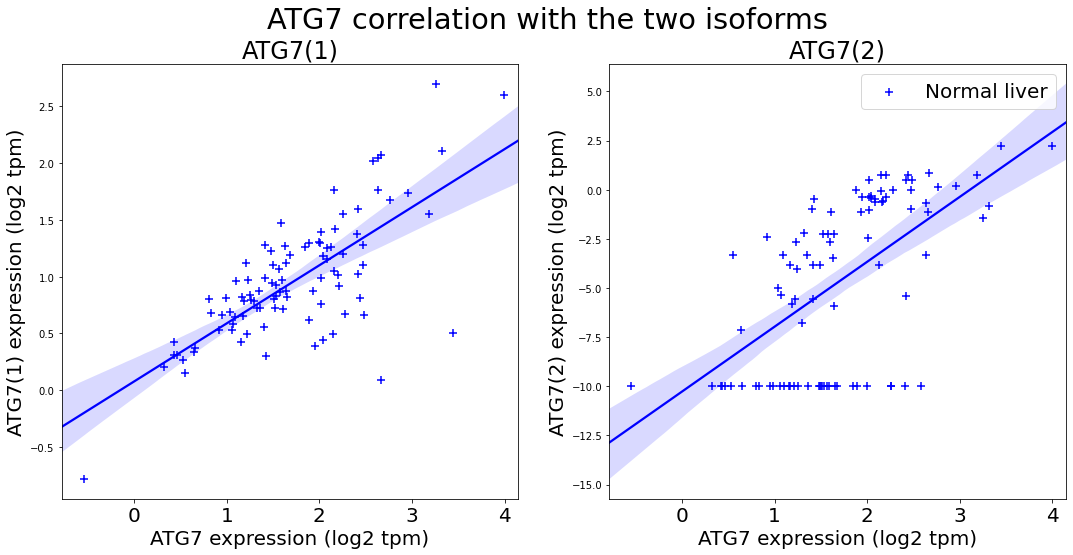

Primary liver : (369, 19387)
 1 are removed from head and tail
 without extremities: (367, 19387)

Primary liver
  correlation between ATG7_1 and ATG7 is: r_value = 0.61 for a p_value of 3.95e-38
  correlation between ATG7_2 and ATG7 is: r_value = 0.52 for a p_value of 2.97e-26


<Figure size 864x576 with 0 Axes>

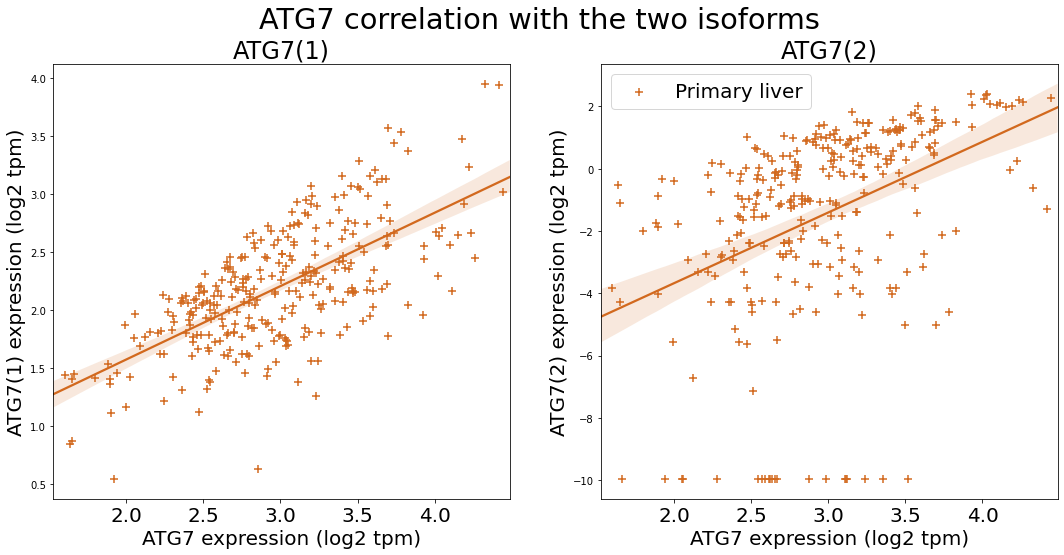


Normal liver : (110, 19387)
 0 are removed from head and tail
 without extremities: (110, 19387)

Normal liver
  correlation between ATG7_1 and ATG7_1 is: r_value = 1.00 for a p_value of 0.00e+00
  correlation between ATG7_2 and ATG7_1 is: r_value = 0.14 for a p_value of 1.33e-01


<Figure size 864x576 with 0 Axes>

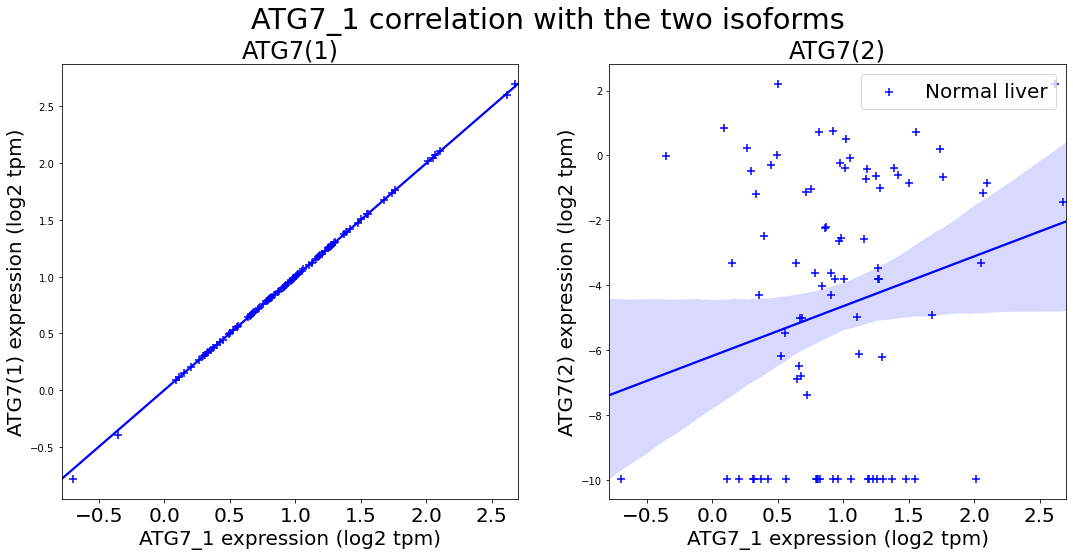

Primary liver : (369, 19387)
 1 are removed from head and tail
 without extremities: (367, 19387)

Primary liver
  correlation between ATG7_1 and ATG7_1 is: r_value = 1.00 for a p_value of 0.00e+00
  correlation between ATG7_2 and ATG7_1 is: r_value = -0.20 for a p_value of 1.57e-04


<Figure size 864x576 with 0 Axes>

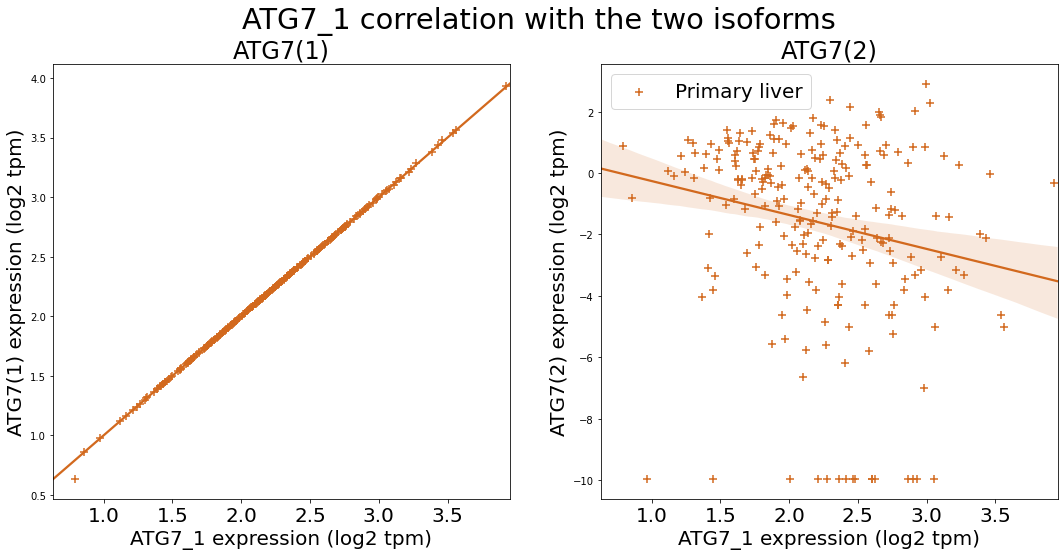


Normal liver : (110, 19387)
 0 are removed from head and tail
 without extremities: (110, 19387)

Normal liver
  correlation between ATG7_1 and MAPK1 is: r_value = 0.45 for a p_value of 9.12e-07
  correlation between ATG7_2 and MAPK1 is: r_value = 0.66 for a p_value of 5.00e-15


<Figure size 864x576 with 0 Axes>

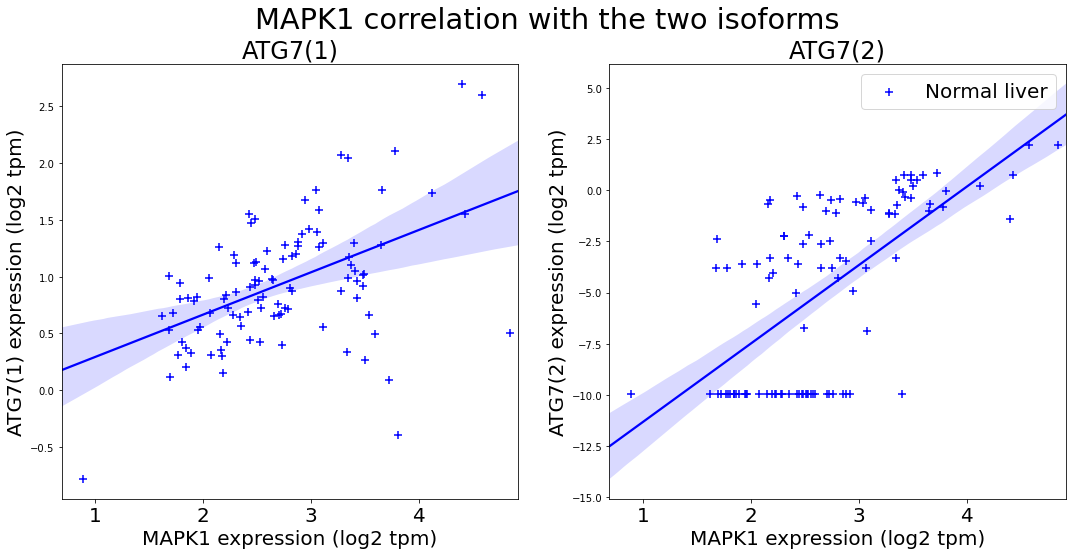

Primary liver : (369, 19387)
 1 are removed from head and tail
 without extremities: (367, 19387)

Primary liver
  correlation between ATG7_1 and MAPK1 is: r_value = -0.09 for a p_value of 7.20e-02
  correlation between ATG7_2 and MAPK1 is: r_value = 0.67 for a p_value of 3.06e-49


<Figure size 864x576 with 0 Axes>

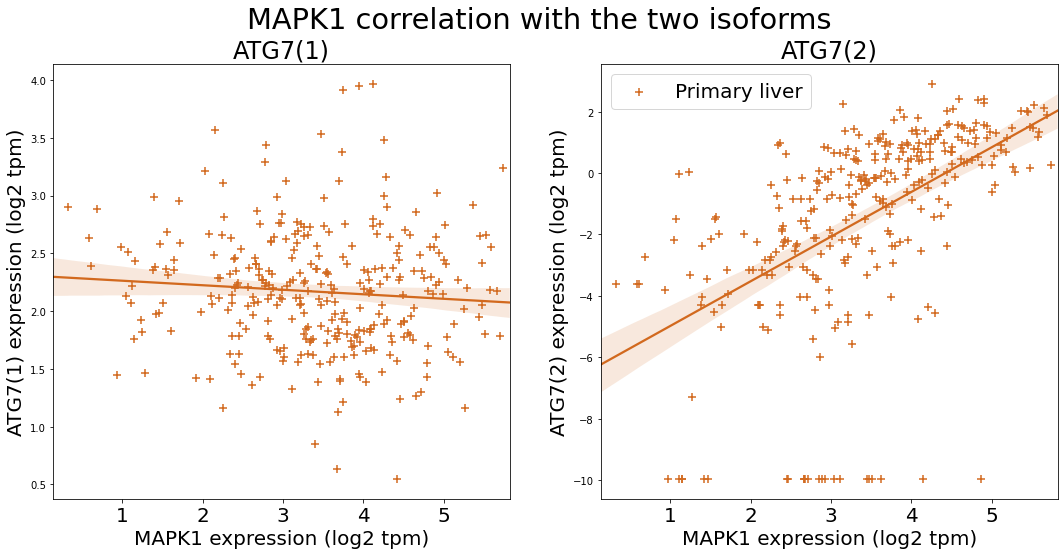


Normal liver : (110, 19387)
 0 are removed from head and tail
 without extremities: (110, 19387)

Normal liver
  correlation between ATG7_1 and MTDH is: r_value = 0.35 for a p_value of 2.02e-04
  correlation between ATG7_2 and MTDH is: r_value = 0.52 for a p_value of 6.68e-09


<Figure size 864x576 with 0 Axes>

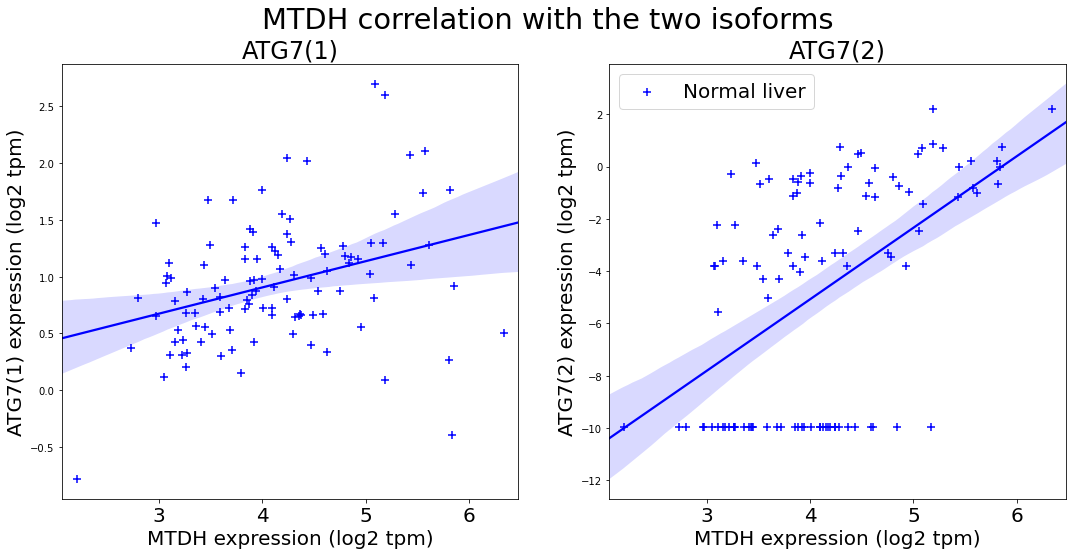

Primary liver : (369, 19387)
 1 are removed from head and tail
 without extremities: (367, 19387)

Primary liver
  correlation between ATG7_1 and MTDH is: r_value = -0.09 for a p_value of 7.88e-02
  correlation between ATG7_2 and MTDH is: r_value = 0.52 for a p_value of 3.52e-27


<Figure size 864x576 with 0 Axes>

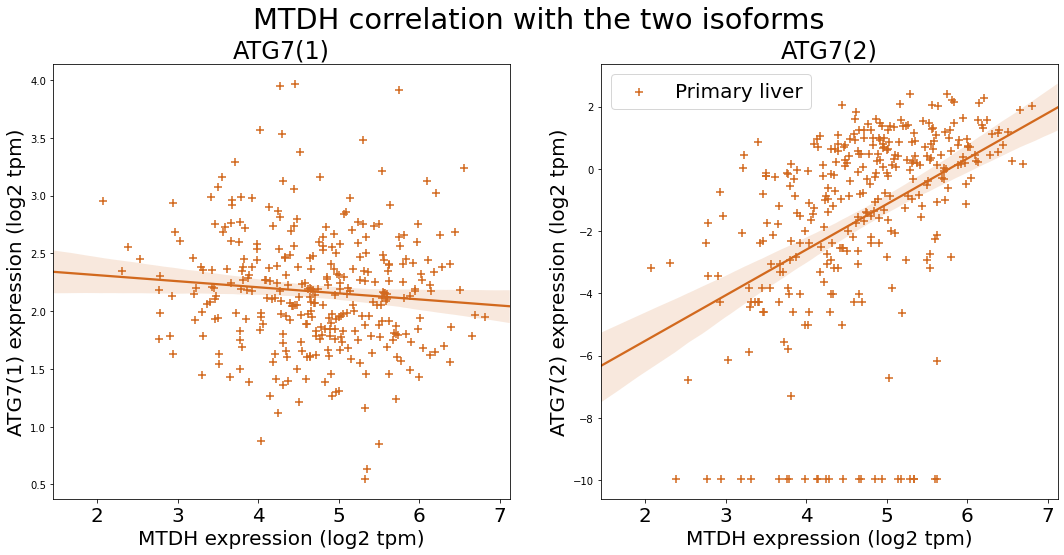


Normal liver : (110, 19387)
 0 are removed from head and tail
 without extremities: (110, 19387)

Normal liver
  correlation between ATG7_1 and KPNA1 is: r_value = 0.33 for a p_value of 3.57e-04
  correlation between ATG7_2 and KPNA1 is: r_value = 0.64 for a p_value of 3.06e-14


<Figure size 864x576 with 0 Axes>

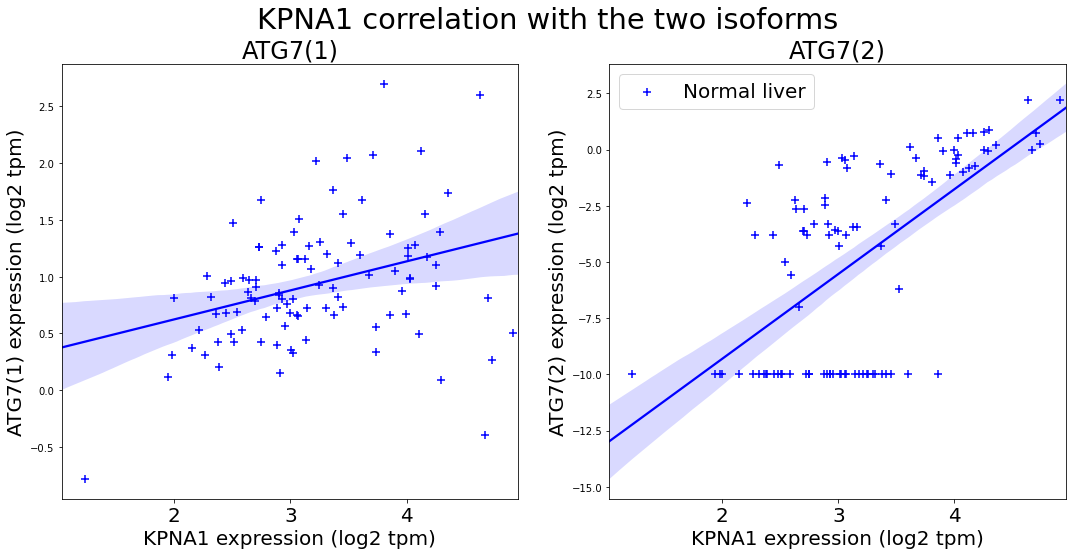

Primary liver : (369, 19387)
 1 are removed from head and tail
 without extremities: (367, 19387)

Primary liver
  correlation between ATG7_1 and KPNA1 is: r_value = -0.23 for a p_value of 7.91e-06
  correlation between ATG7_2 and KPNA1 is: r_value = 0.75 for a p_value of 8.13e-68


<Figure size 864x576 with 0 Axes>

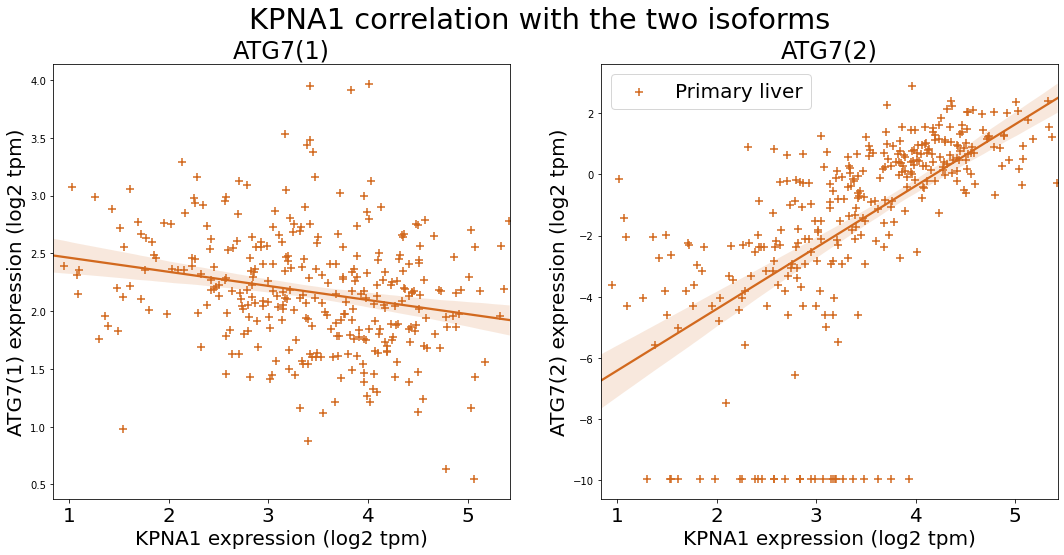


Normal liver : (110, 19387)
 0 are removed from head and tail
 without extremities: (110, 19387)

Normal liver
  correlation between ATG7_1 and TNPO1 is: r_value = 0.47 for a p_value of 2.00e-07
  correlation between ATG7_2 and TNPO1 is: r_value = 0.59 for a p_value of 7.47e-12


<Figure size 864x576 with 0 Axes>

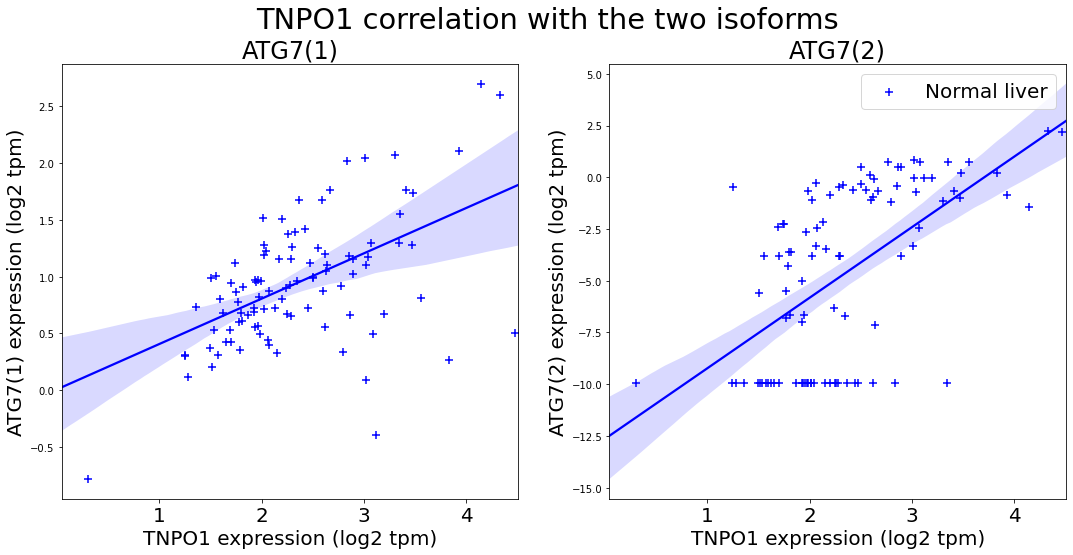

Primary liver : (369, 19387)
 1 are removed from head and tail
 without extremities: (367, 19387)

Primary liver
  correlation between ATG7_1 and TNPO1 is: r_value = 0.03 for a p_value of 5.88e-01
  correlation between ATG7_2 and TNPO1 is: r_value = 0.67 for a p_value of 5.91e-50


<Figure size 864x576 with 0 Axes>

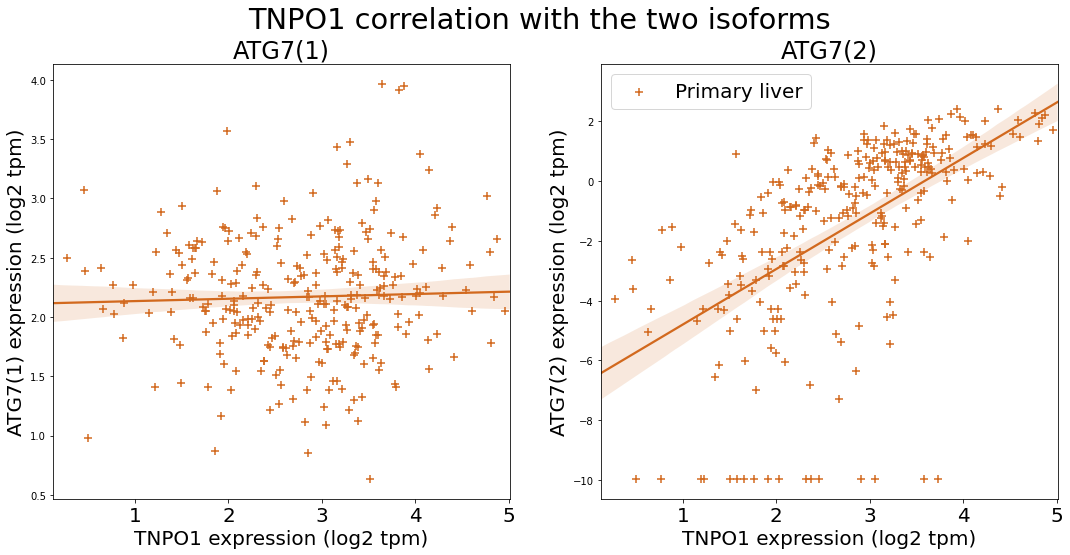


Normal liver : (110, 19387)
 0 are removed from head and tail
 without extremities: (110, 19387)

Normal liver
  correlation between ATG7_1 and HK2 is: r_value = 0.44 for a p_value of 1.57e-06
  correlation between ATG7_2 and HK2 is: r_value = 0.27 for a p_value of 3.86e-03


<Figure size 864x576 with 0 Axes>

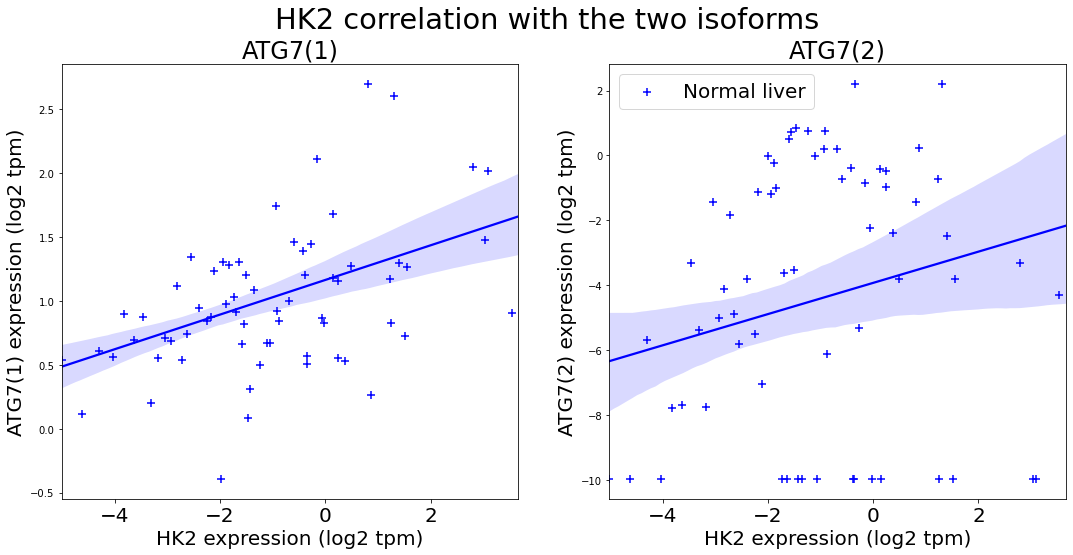

Primary liver : (369, 19387)
 1 are removed from head and tail
 without extremities: (367, 19387)

Primary liver
  correlation between ATG7_1 and HK2 is: r_value = 0.26 for a p_value of 5.04e-07
  correlation between ATG7_2 and HK2 is: r_value = 0.13 for a p_value of 1.33e-02


<Figure size 864x576 with 0 Axes>

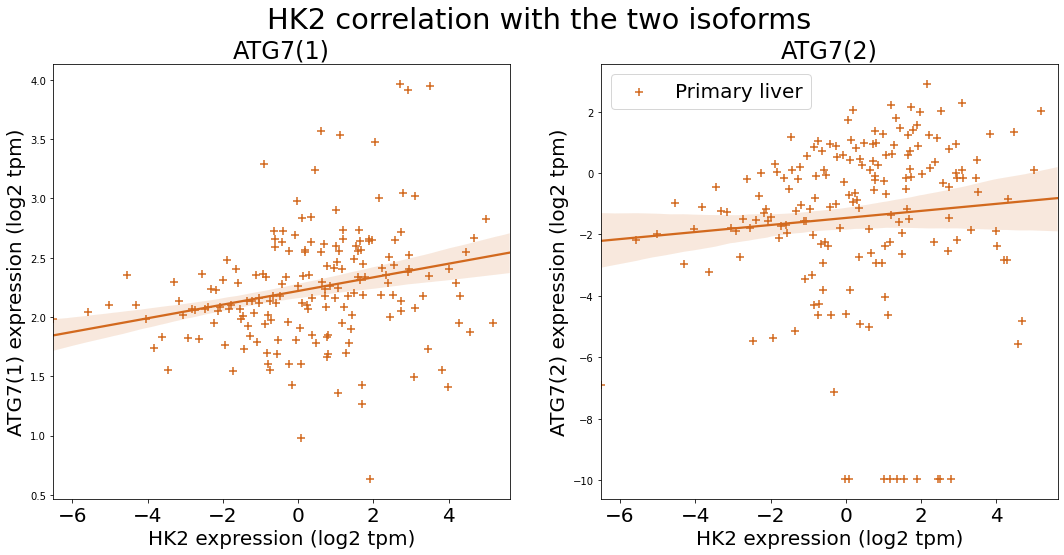


Normal liver : (110, 19387)
 0 are removed from head and tail
 without extremities: (110, 19387)

Normal liver
  correlation between ATG7_1 and YAP1 is: r_value = 0.42 for a p_value of 3.78e-06
  correlation between ATG7_2 and YAP1 is: r_value = 0.43 for a p_value of 3.39e-06


<Figure size 864x576 with 0 Axes>

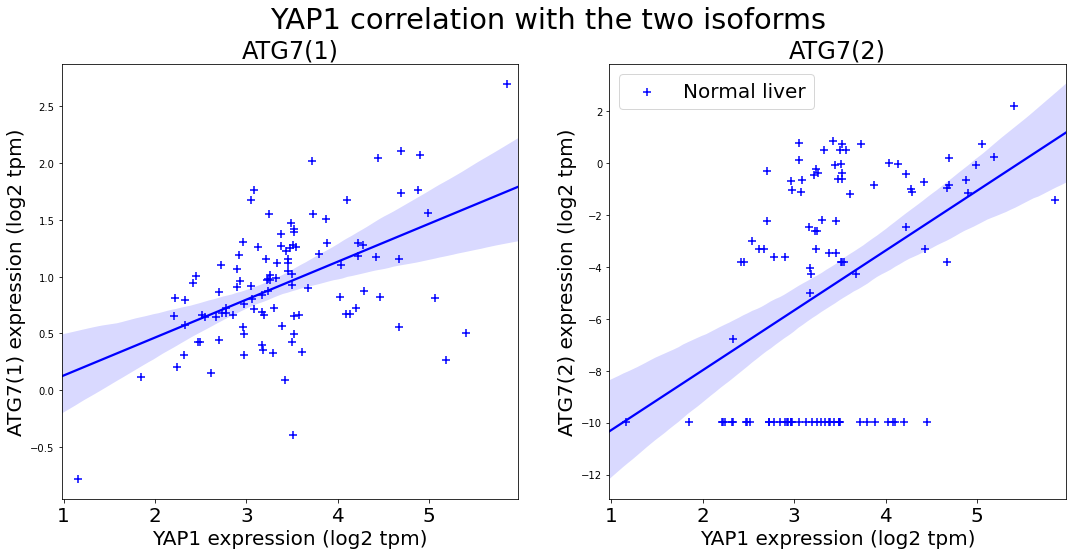

Primary liver : (369, 19387)
 1 are removed from head and tail
 without extremities: (367, 19387)

Primary liver
  correlation between ATG7_1 and YAP1 is: r_value = -0.01 for a p_value of 8.55e-01
  correlation between ATG7_2 and YAP1 is: r_value = 0.52 for a p_value of 3.48e-27


<Figure size 864x576 with 0 Axes>

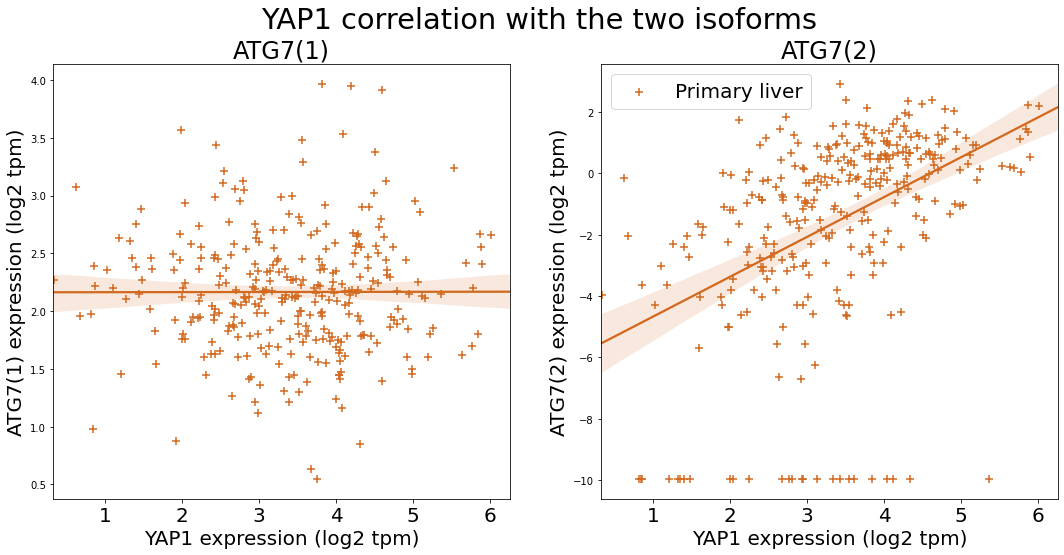


Normal liver : (110, 19387)
 0 are removed from head and tail
 without extremities: (110, 19387)

Normal liver
  correlation between ATG7_1 and AJUBA is: r_value = 0.38 for a p_value of 4.38e-05
  correlation between ATG7_2 and AJUBA is: r_value = 0.12 for a p_value of 2.02e-01


<Figure size 864x576 with 0 Axes>

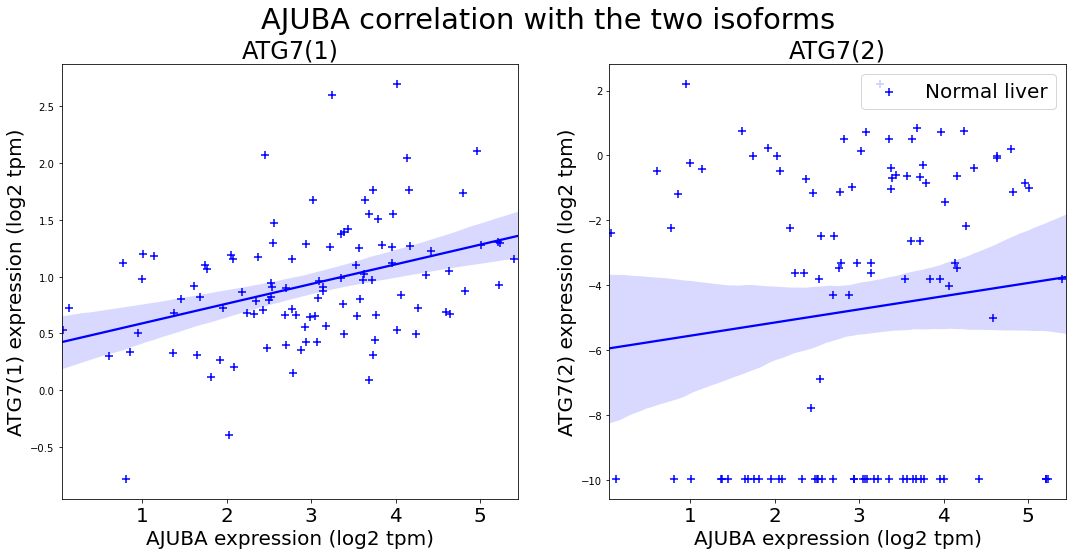

Primary liver : (369, 19387)
 1 are removed from head and tail
 without extremities: (367, 19387)

Primary liver
  correlation between ATG7_1 and AJUBA is: r_value = -0.02 for a p_value of 6.34e-01
  correlation between ATG7_2 and AJUBA is: r_value = 0.39 for a p_value of 1.47e-14


<Figure size 864x576 with 0 Axes>

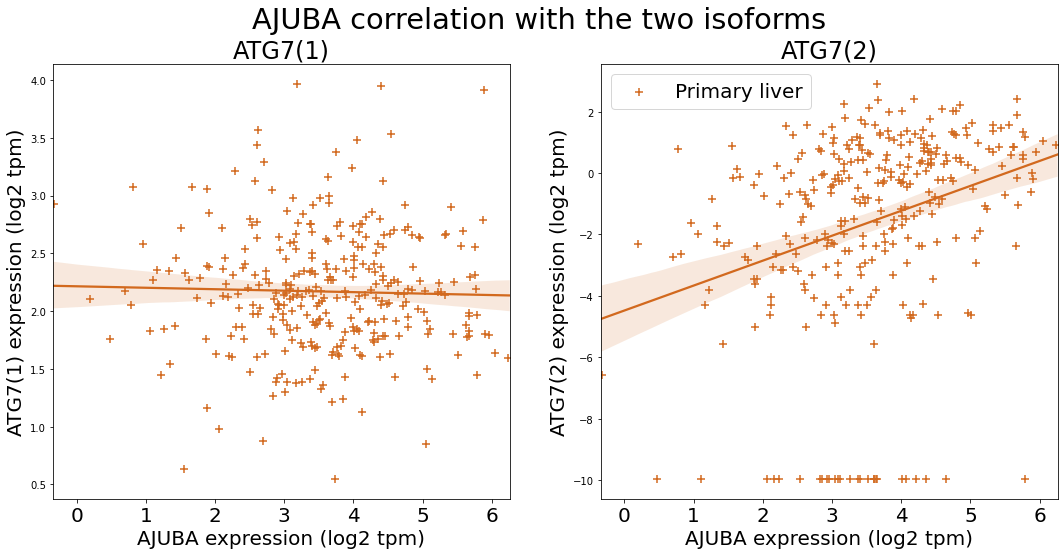


Normal liver : (110, 19387)
 0 are removed from head and tail
 without extremities: (110, 19387)

Normal liver
  correlation between ATG7_1 and YBX1 is: r_value = 0.59 for a p_value of 8.79e-12
  correlation between ATG7_2 and YBX1 is: r_value = 0.58 for a p_value of 4.43e-11


<Figure size 864x576 with 0 Axes>

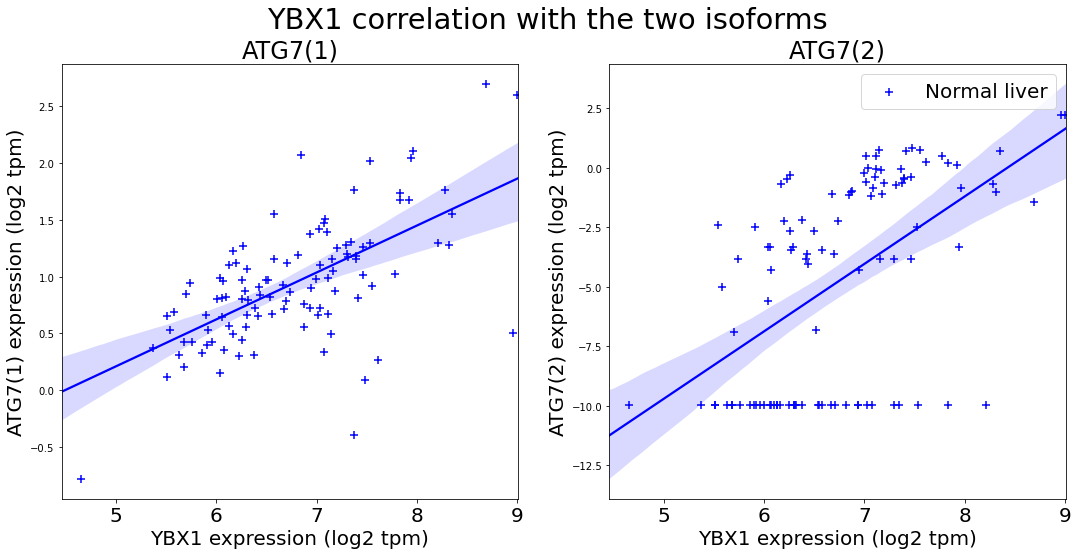

Primary liver : (369, 19387)
 1 are removed from head and tail
 without extremities: (367, 19387)

Primary liver
  correlation between ATG7_1 and YBX1 is: r_value = 0.35 for a p_value of 8.17e-12
  correlation between ATG7_2 and YBX1 is: r_value = 0.35 for a p_value of 5.89e-12


<Figure size 864x576 with 0 Axes>

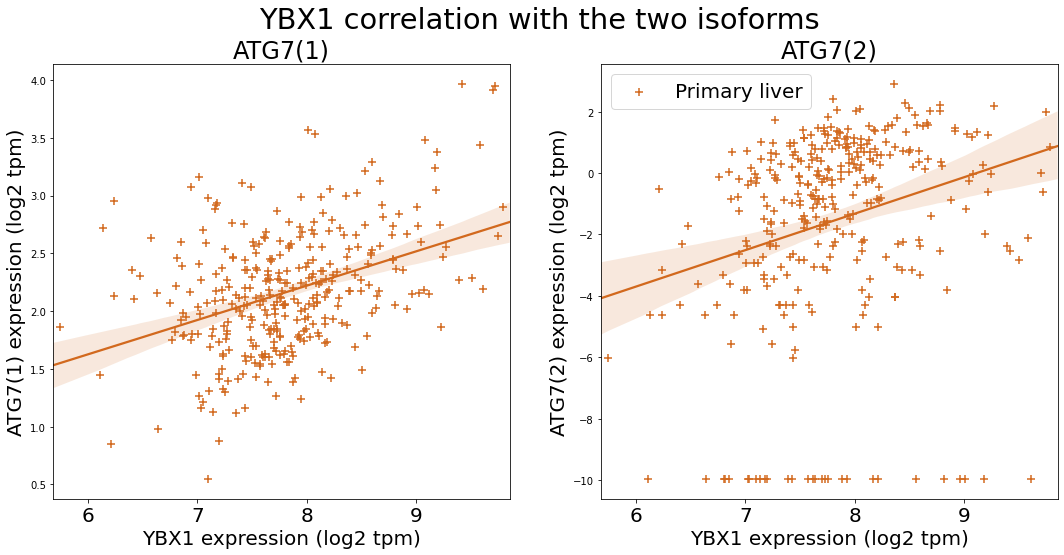


Normal liver : (110, 19387)
 0 are removed from head and tail
 without extremities: (110, 19387)

Normal liver
  correlation between ATG7_1 and TGFB1 is: r_value = 0.56 for a p_value of 2.37e-10
  correlation between ATG7_2 and TGFB1 is: r_value = 0.36 for a p_value of 8.85e-05


<Figure size 864x576 with 0 Axes>

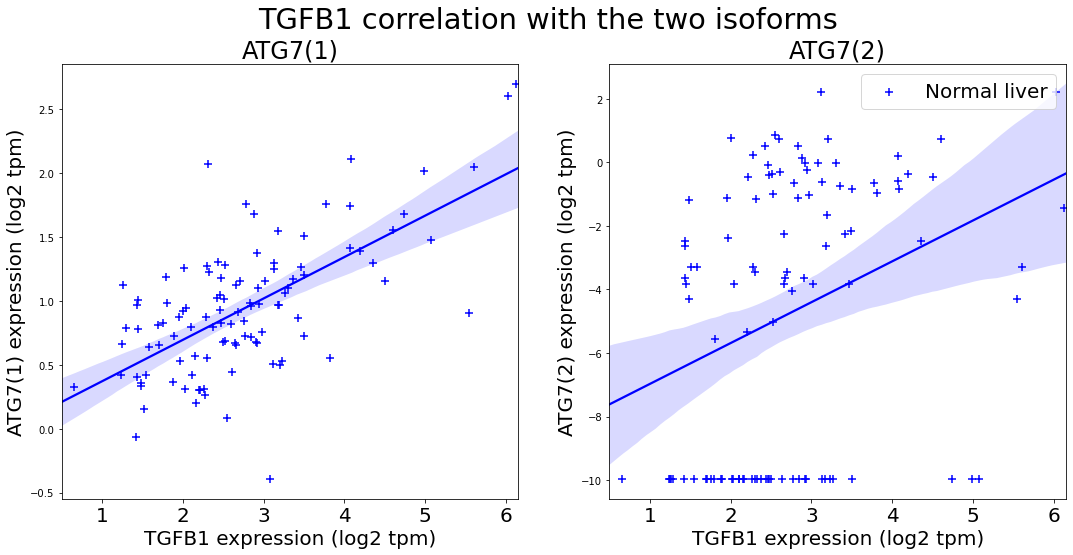

Primary liver : (369, 19387)
 1 are removed from head and tail
 without extremities: (367, 19387)

Primary liver
  correlation between ATG7_1 and TGFB1 is: r_value = 0.43 for a p_value of 8.10e-18
  correlation between ATG7_2 and TGFB1 is: r_value = 0.06 for a p_value of 2.29e-01


<Figure size 864x576 with 0 Axes>

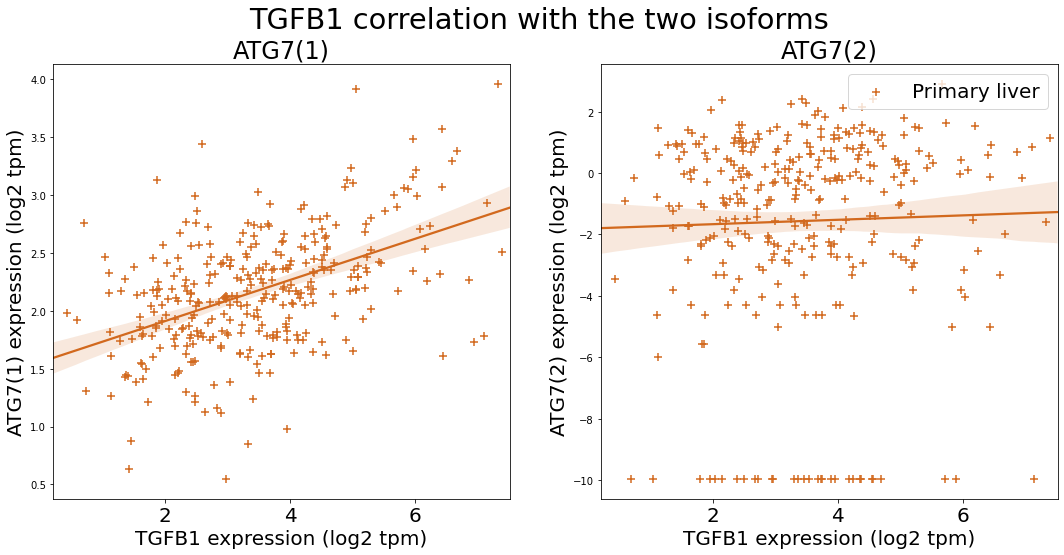


Wall time: 3min 21s


<Figure size 864x576 with 0 Axes>

In [51]:
%%time
#Graphic representation, two graphs in one, remove the extremities to have better graph

all_tissue_used = [[normal_liver_protcoding_atg7_expr,'Normal liver', 'blue'], 
                   [primary_liver_protcoding_atg7_expr,'Primary liver', 'chocolate']]

HK2 = 'ENSG00000159399'
YAP1 = 'ENSG00000137693'
AJUBA = 'ENSG00000129474'
YBX1 = 'ENSG00000065978'
TGFB1 = 'ENSG00000105329'
MAPK1 = 'ENSG00000100030'
MTDH = 'ENSG00000147649'
KPNA1 = 'ENSG00000114030'
TNPO1 = 'ENSG00000083312'
ATG7 = 'ATG7'
ATG7_1 = 'ATG7_1'
 
genes = [[ATG7,'ATG7'], [ATG7_1,'ATG7_1'], [MAPK1,'MAPK1'], [MTDH,'MTDH'], [KPNA1,'KPNA1'], 
         [TNPO1,'TNPO1'], [HK2,'HK2'], [YAP1,'YAP1'], [AJUBA,'AJUBA'], [YBX1,'YBX1'], [TGFB1,'TGFB1']]

for gene in genes:
    for df in all_tissue_used:
        #sort by value, remove the extremities
        print(df[1], ':', df[0].shape)
        for_genes = df[0].sort_values([gene[0]], ascending = False) 
        lenght = len(for_genes)
        without_05perc = int(lenght*0.005)
        without_head = without_05perc
        without_tail = lenght - without_05perc
        print('', without_05perc, 'are removed from head and tail')
                
        df_no_extrem = for_genes.iloc[without_head:without_tail,:]
        print(' without extremities:', df_no_extrem.shape)
        print()
        
        x = df_no_extrem[gene[0]].to_list()
        y1 = df_no_extrem['ATG7_1'].to_list()
        y2 = df_no_extrem['ATG7_2'].to_list()
        
        
        print(df[1])
        r_value, p_value = scipy.stats.spearmanr(x, y1)
        print('  correlation between ATG7_1 and', gene[1],  'is:', 'r_value = {:.2f} for a p_value of {:.2e}'.format(r_value, p_value))
        r_value, p_value = scipy.stats.spearmanr(x, y2)
        print('  correlation between ATG7_2 and', gene[1],  'is:', 'r_value = {:.2f} for a p_value of {:.2e}'.format(r_value, p_value))
        
        #graph
        fig, ax = plt.subplots(1,2, figsize=(18,8))
        name = gene[1]+ " correlation with the two isoforms"
        name2 = gene[1]+ " expression (log2 tpm)"

        fig.suptitle(name, fontsize="x-large")
 
        fig = seaborn.regplot(x=x,y=y1, ax=ax[0], x_bins=500, x_ci = 0, marker="+", label = df[1], color = df[2])
        fig.set_title("ATG7(1)")
        fig.set_xlabel(name2)
        fig.set_ylabel('ATG7(1) expression (log2 tpm)')

        fig = seaborn.regplot(x=x,y=y2, ax=ax[1], x_bins=500, x_ci = 0, marker="+", label = df[1], color = df[2])
        fig.set_title("ATG7(2)")
        fig.set_xlabel(name2)
        fig.set_ylabel('ATG7(2) expression (log2 tpm)')
        plt.legend()
        plt.show()
        plt.clf()
    print()

# V] Distribution of all rvalue to select cutoff

In [52]:
all_positiv_corr_spearman[1]

,ensembl_gene_id,hgnc_symbol,r_value,p_value,info
3432,ENSG00000140718,FTO,0.715442,1.61241e-18,Normal_liver_ATG7_2
4389,ENSG00000152291,TGOLN2,0.714981,1.73561e-18,Normal_liver_ATG7_2
3598,ENSG00000057608,GDI2,0.708114,5.10138e-18,Normal_liver_ATG7_2
7148,ENSG00000123444,KBTBD4,0.707387,5.708e-18,Normal_liver_ATG7_2
3567,ENSG00000072501,SMC1A,0.703627,1.01498e-17,Normal_liver_ATG7_2
...,...,...,...,...,...
885,ENSG00000141994,DUS3L,0.000459345,0.9962,Normal_liver_ATG7_2
6465,ENSG00000099797,TECR,0.000338708,0.997198,Normal_liver_ATG7_2
3070,ENSG00000155287,SLC25A28,0.000215753,0.998215,Normal_liver_ATG7_2
1799,ENSG00000154079,SDHAF4,0.000204161,0.998311,Normal_liver_ATG7_2


Normal liver, ATG7(1)
shape positiv (1109, 5)
shape negativ (11548, 5)
shape after merge (12657, 5)

Normal liver, ATG7(2)
shape positiv (3151, 5)
shape negativ (9506, 5)
shape after merge (12657, 5)

Primary liver, ATG7(1)
shape positiv (4268, 5)
shape negativ (11302, 5)
shape after merge (15570, 5)

Primary liver, ATG7(2)
shape positiv (2401, 5)
shape negativ (13169, 5)
shape after merge (15570, 5)

shape normal (12657, 5)
shape primary (12657, 5)
shape after merge (25314, 5)

shape normal (15570, 5)
shape primary (15570, 5)
shape after merge (31140, 5)



findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans.


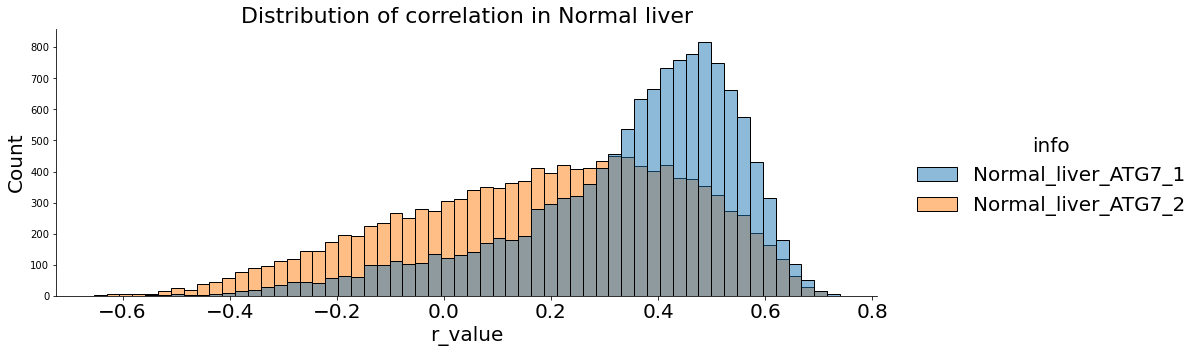

<Figure size 864x576 with 0 Axes>

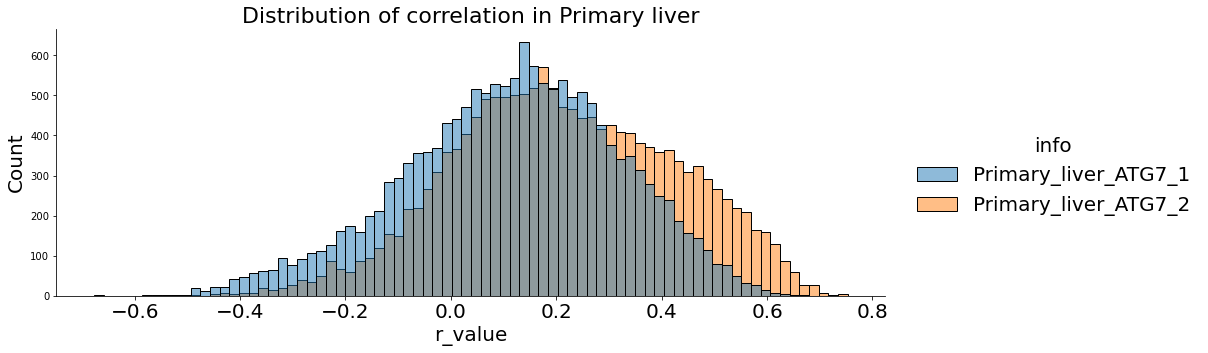


Wall time: 1.57 s


<Figure size 864x576 with 0 Axes>

In [53]:
%%time
#Merge Negative and Positive data
data =  [
         [all_negativ_corr_spearman[0], all_positiv_corr_spearman[0], 'Normal liver, ATG7(1)'], 
         [all_negativ_corr_spearman[1], all_positiv_corr_spearman[1], 'Normal liver, ATG7(2)'],
         [all_negativ_corr_spearman[2], all_positiv_corr_spearman[2], 'Primary liver, ATG7(1)'], 
         [all_negativ_corr_spearman[3], all_positiv_corr_spearman[3], 'Primary liver, ATG7(2)']
         ]

all_corr_negpos_merged = []
for dfs in data:
  print(dfs[2])
  print('shape positiv', dfs[0].shape)
  print('shape negativ', dfs[1].shape)

  df_merged = pandas.concat([dfs[0], dfs[1]], axis=0)
  df_merged = df_merged.reset_index(drop = True)
  print('shape after merge', df_merged.shape)
  all_corr_negpos_merged.append(df_merged)
  print()

#Merge ATG7(1) and ATG7(2)
data = [
        [all_corr_negpos_merged[0], all_corr_negpos_merged[1], 'Normal liver'],
        [all_corr_negpos_merged[2], all_corr_negpos_merged[3], 'Primary liver']
        ]

all_corr_isoforms_merged = []
for dfs in data:
  print('shape normal', dfs[0].shape)
  print('shape primary', dfs[1].shape)

  df_merged = pandas.concat([dfs[0], dfs[1]], axis=0)
  df_merged = df_merged.reset_index(drop = True)
  print('shape after merge', df_merged.shape)
  all_corr_isoforms_merged.append(df_merged)
  print()

#Distribution of correlation
data = [
        [all_corr_isoforms_merged[0], 'Normal liver'],
        [all_corr_isoforms_merged[1], 'Primary liver']
        ]

for dfs in data:
  seaborn.displot(dfs[0], x="r_value", hue='info', aspect = 2.6)
  label_title = 'Distribution of correlation in ' + dfs[1]
  plt.title(label_title, fontsize = 22)
  plt.show()
  plt.clf()
  print()

In [136]:
#GABARAP is not very correlated
for df in all_corr_isoforms_merged:
    print(df.loc[df['hgnc_symbol'] == 'GABARAP'])

       ensembl_gene_id hgnc_symbol   r_value      p_value                 info
1110   ENSG00000170296     GABARAP  0.730256  1.40199e-19  Normal_liver_ATG7_1
18134  ENSG00000170296     GABARAP  0.441251  1.39999e-06  Normal_liver_ATG7_2
       ensembl_gene_id hgnc_symbol    r_value      p_value  \
5648   ENSG00000170296     GABARAP   0.386479  1.35998e-14   
15962  ENSG00000170296     GABARAP -0.0205191     0.694421   

                       info  
5648   Primary_liver_ATG7_1  
15962  Primary_liver_ATG7_2  


In [138]:
all_positiv_corr_spearman[0]

,ensembl_gene_id,hgnc_symbol,r_value,p_value,info
9487,ENSG00000104979,C19orf53,0.739929,2.60296e-20,Normal_liver_ATG7_1
11016,ENSG00000170296,GABARAP,0.730256,1.40199e-19,Normal_liver_ATG7_1
3909,ENSG00000124357,NAGK,0.729068,1.71528e-19,Normal_liver_ATG7_1
9967,ENSG00000167770,OTUB1,0.72825,1.96977e-19,Normal_liver_ATG7_1
5335,ENSG00000135622,SEMA4F,0.725058,3.36342e-19,Normal_liver_ATG7_1
...,...,...,...,...,...
4363,ENSG00000132561,MATN2,0.00119704,0.990098,Normal_liver_ATG7_1
4278,ENSG00000123728,RAP2C,0.00110462,0.990862,Normal_liver_ATG7_1
2508,ENSG00000151276,MAGI1,0.000759717,0.993715,Normal_liver_ATG7_1
8804,ENSG00000123358,NR4A1,0.000486928,0.995972,Normal_liver_ATG7_1


In [150]:
#To know if HK2 is positively or negativly correlated
for df in all_corr_isoforms_merged:
    print(df.loc[df['hgnc_symbol'] == 'HK2'])
    print()
    #positivly regulated
    
#to know the rank 
for df in all_positiv_corr_spearman:
    df.reset_index(drop = True)
    print(df.loc[df['hgnc_symbol'] == 'HK2'])

       ensembl_gene_id hgnc_symbol   r_value     p_value                 info
6187   ENSG00000159399         HK2  0.439394  1.5682e-06  Normal_liver_ATG7_1
21106  ENSG00000159399         HK2  0.273312  0.00386479  Normal_liver_ATG7_2

       ensembl_gene_id hgnc_symbol   r_value     p_value                  info
8274   ENSG00000159399         HK2  0.255548  6.5212e-07  Primary_liver_ATG7_1
27701  ENSG00000159399         HK2  0.136603  0.00860203  Primary_liver_ATG7_2

      ensembl_gene_id hgnc_symbol   r_value     p_value                 info
5078  ENSG00000159399         HK2  0.439394  1.5682e-06  Normal_liver_ATG7_1
      ensembl_gene_id hgnc_symbol   r_value     p_value                 info
3813  ENSG00000159399         HK2  0.273312  0.00386479  Normal_liver_ATG7_2
      ensembl_gene_id hgnc_symbol   r_value     p_value                  info
4368  ENSG00000159399         HK2  0.255548  6.5212e-07  Primary_liver_ATG7_1
      ensembl_gene_id hgnc_symbol   r_value     p_value        

   ensembl_gene_id hgnc_symbol   r_value      p_value                 info
1  ENSG00000170296     GABARAP  0.730256  1.40199e-19  Normal_liver_ATG7_1
      ensembl_gene_id hgnc_symbol   r_value      p_value                 info
9079  ENSG00000170296     GABARAP  0.441251  1.39999e-06  Normal_liver_ATG7_2
       ensembl_gene_id hgnc_symbol   r_value      p_value  \
10735  ENSG00000170296     GABARAP  0.386479  1.35998e-14   

                       info  
10735  Primary_liver_ATG7_1  
Empty DataFrame
Columns: [ensembl_gene_id, hgnc_symbol, r_value, p_value, info]
Index: []


In [134]:
# have to select the 1% in extremities to have only the interesting one.
print((len(all_corr_negpos_merged)), '= norm iso1, norm iso2, prim iso1, prim iso2')

4 = norm iso1, norm iso2, prim iso1, prim iso2


In [55]:
all_corr_negpos_extremities = []

for df in all_corr_negpos_merged:
  df = df.sort_values(['r_value'], ascending = False)
  df = df.reset_index(drop = True)
  
  lenght = len(df)
  only_1perc = int(lenght*0.01)
  just_head = only_1perc
  just_tail = lenght - only_1perc

  df_head = df.iloc[0:just_head,:]
  df_tail = df.iloc[just_tail:,:]
  df_extremeties = pandas.concat([df_head, df_tail], axis=0)

  inform = df['info'][1]
  extremities_name = 'corr_1%extremities'+ '_' +inform
#   df_extremeties.to_excel(extremities_name+'.xlsx', index=False)

  all_corr_negpos_extremities.append(df_extremeties)

# VI] Venn diagrams

In [128]:
#to know the ensembl code for HK2
protein_coding_list.loc[protein_coding_list['hgnc_symbol'] == 'HK2']

,ensembl_gene_id,hgnc_symbol,entrezgene_id,transcript_biotype
10895,ENSG00000159399,HK2,3099.0,protein_coding


In [56]:
len(all_corr_negpos_extremities)

4

In [57]:
all_corr_negpos_extremities[0]

,ensembl_gene_id,hgnc_symbol,r_value,p_value,info
0,ENSG00000104979,C19orf53,0.739929,2.60296e-20,Normal_liver_ATG7_1
1,ENSG00000170296,GABARAP,0.730256,1.40199e-19,Normal_liver_ATG7_1
2,ENSG00000124357,NAGK,0.729068,1.71528e-19,Normal_liver_ATG7_1
3,ENSG00000167770,OTUB1,0.72825,1.96977e-19,Normal_liver_ATG7_1
4,ENSG00000135622,SEMA4F,0.725058,3.36342e-19,Normal_liver_ATG7_1
...,...,...,...,...,...
12652,ENSG00000198888,MT-ND1,-0.4937,4.2413e-08,Normal_liver_ATG7_1
12653,ENSG00000198899,MT-ATP6,-0.499963,2.68295e-08,Normal_liver_ATG7_1
12654,ENSG00000212907,MT-ND4L,-0.502289,2.25791e-08,Normal_liver_ATG7_1
12655,ENSG00000198712,MT-CO2,-0.523254,4.49567e-09,Normal_liver_ATG7_1


In [58]:
#separate pos and neg correlation
all_corr_positiv_extremities = []
all_corr_negativ_extremities = []

for df in all_corr_negpos_extremities:
    data_pos = df[df['r_value']>0]
    data_neg = df[df['r_value']<0]
    all_corr_positiv_extremities.append(data_pos)
    all_corr_negativ_extremities.append(data_neg)
len(all_corr_positiv_extremities)

4

In [59]:
len(all_corr_negativ_extremities[1])

126

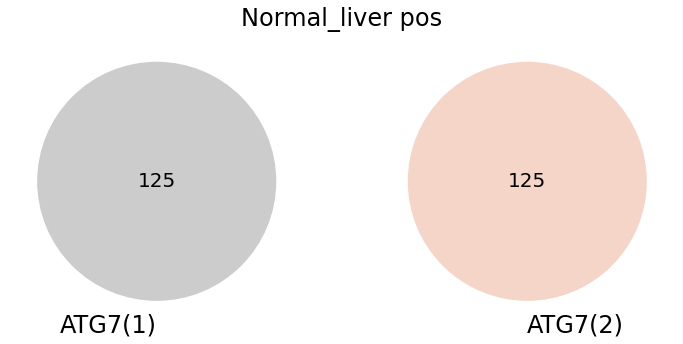

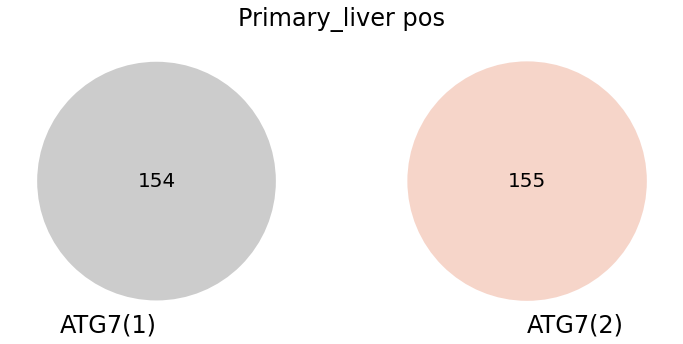

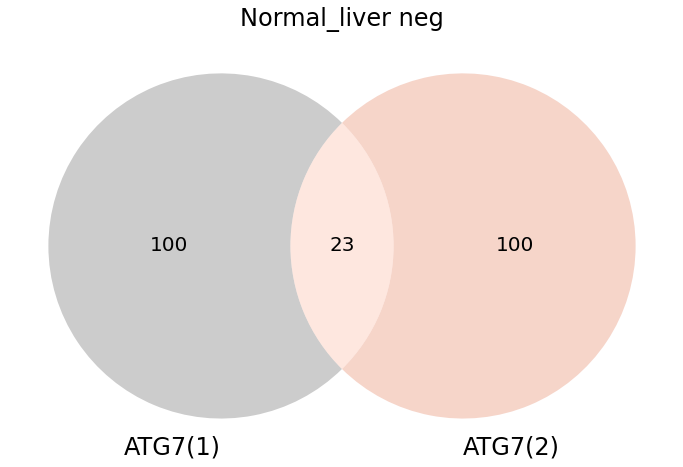

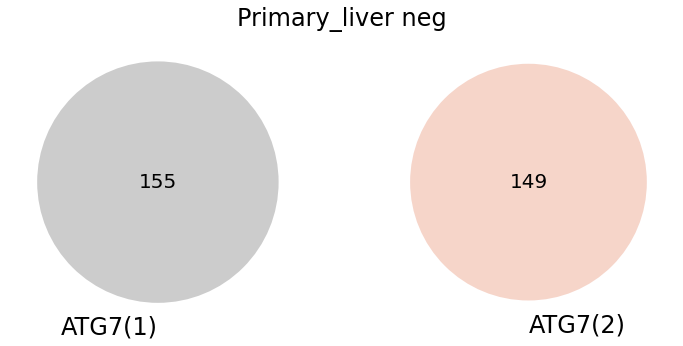

<Figure size 864x576 with 0 Axes>

In [60]:
#VENN DIAGRAMS FOR the 1% of the genes + save
data_pos =  [
         [all_corr_positiv_extremities[0], all_corr_positiv_extremities[1], 'Normal_liver', 'pos'], 
         [all_corr_positiv_extremities[2], all_corr_positiv_extremities[3], 'Primary_liver', 'pos']
         ]

data_neg =  [
         [all_corr_negativ_extremities[0], all_corr_negativ_extremities[1], 'Normal_liver', 'neg'], 
         [all_corr_negativ_extremities[2], all_corr_negativ_extremities[3], 'Primary_liver', 'neg']
         ]

data = data_pos + data_neg

for dfs in data:
    set1 = set(dfs[0]['hgnc_symbol'])
    set2 = set(dfs[1]['hgnc_symbol'])
    subset = (set1, set2)

    #save results in list
    with_only1 = list(set2.symmetric_difference(set1) & set1)
    with_only2 = list(set2.symmetric_difference(set1) & set2)
    intersection = set1.intersection(set2)

    #create a dictionnary
    d = dict(Only_ATG7_1 = with_only1, Only_ATG7_2 = with_only2, Intersection= intersection)

    #Convert to dataframe
    df_only_and_intersection = pandas.DataFrame.from_dict(d, orient='index')
    name_file = 'only_and_intersection_isos'+dfs[2]+' '+dfs[3]
       
    #Transpose to have a better table and save
    df_only_and_intersection = df_only_and_intersection.transpose()
    df_only_and_intersection['info'] = dfs[2]+dfs[3]
    df_only_and_intersection.to_excel(name_file+'.xlsx', index=False)
    
    #Venn Diagram
    venn2(subset, set_labels=('ATG7(1)', 'ATG7(2)'), set_colors=('grey', 'darksalmon'))
    label_title = dfs[2] + ' ' + dfs[3]
    plt.title(label_title)
    plt.show()
    plt.clf()
    print()

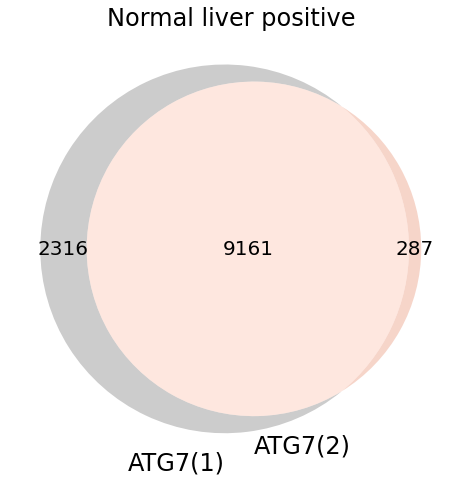

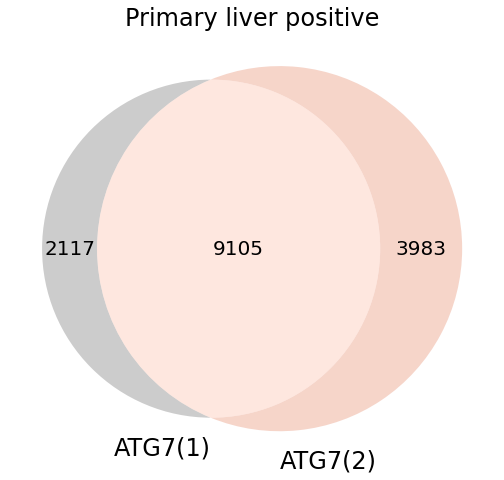

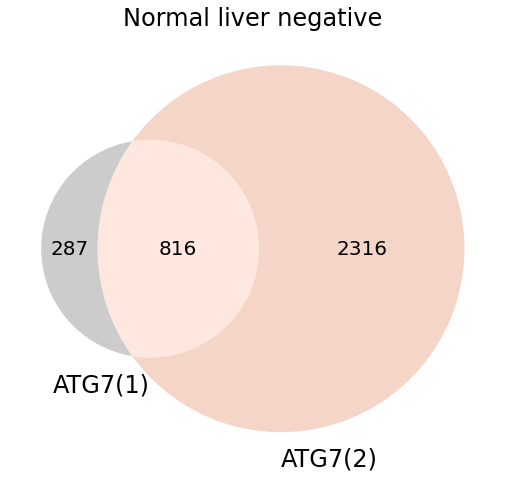

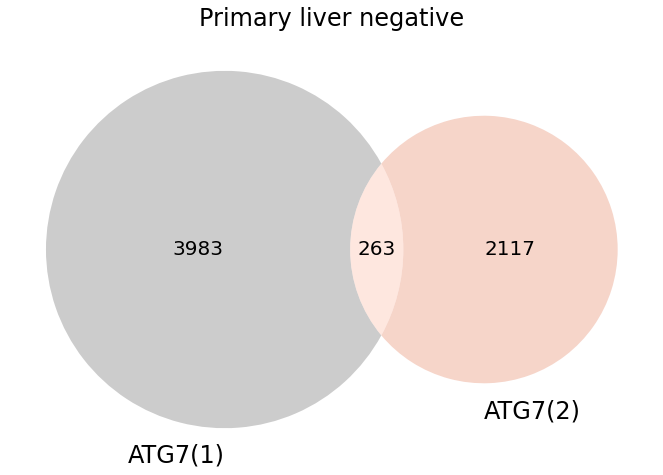

<Figure size 864x576 with 0 Axes>

In [61]:
#VENN DIAGRAMS FOR 100% of the genes

data_pos =  [
         [all_positiv_corr_spearman[0], all_positiv_corr_spearman[1], 'Normal liver', 'positive'], 
         [all_positiv_corr_spearman[2], all_positiv_corr_spearman[3], 'Primary liver', 'positive']
         ]

data_neg =  [
         [all_negativ_corr_spearman[0], all_negativ_corr_spearman[1], 'Normal liver', 'negative'], 
         [all_negativ_corr_spearman[2], all_negativ_corr_spearman[3], 'Primary liver', 'negative']
         ]

data = data_pos + data_neg

list_only1 = []
list_only2 = []

for dfs in data:
  set1 = set(dfs[0]['ensembl_gene_id'])
  set2 = set(dfs[1]['ensembl_gene_id'])
  subset = (set1, set2)

  #just to save some results in list
  with_only1 = set2.symmetric_difference(set1) & set1
  list_only1.append(with_only1)

  with_only2 = set2.symmetric_difference(set1) & set2
  list_only2.append(with_only2)

  #Venn Diagram
  venn2(subset, set_labels=('ATG7(1)', 'ATG7(2)'), set_colors=('grey', 'darksalmon'))
  label_title = dfs[2] + ' ' + dfs[3]
  plt.title(label_title)
  plt.show()
  plt.clf()
  print()



In [127]:
len(all_corr_negpos_extremities)

4